# Importing Libraries and Setting Configurations

In this section, we import the necessary libraries for data manipulation, visualization, and machine learning. These libraries include pandas and numpy for data handling, scikit-learn for machine learning, and matplotlib/seaborn for visualization. Additionally, we configure some global settings, such as the number of top actors, roles, and companies to consider, and the plotting style for consistent visualizations.

In [ ]:
import pandas as pd
import numpy as np
import re
import ast
from collections import Counter, defaultdict
import nltk
from nltk.corpus import stopwords
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt
import seaborn as sns
import time
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Ridge, Lasso
import xgboost as xgb
import lightgbm as lgb
import copy
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import (
    r2_score,
    mean_squared_error,
    mean_absolute_error,
    mean_absolute_percentage_error,
)

# Configuration parameters
TOP_N_ACTORS = 150  # Number of top actors to consider
TOP_M_ROLES = 5  # Number of top roles per actor
TOP_N_PER_ROLE = 100  # Maximum samples per role
TOP_N_COMPANIES = 200  # Number of top production companies to consider
MAX_SYNOPSIS_FEATURES = 1000  # Max TF-IDF features for movie synopses
VIS_TOP_N = 15  # Number of top items to display in visualizations

# Plotting settings
sns.set_style("whitegrid")
plt.rcParams["figure.figsize"] = (12, 7)
plt.rcParams["axes.titlesize"] = 16
plt.rcParams["axes.labelsize"] = 12

# Pandas display settings
pd.options.display.max_columns = None
pd.options.display.max_rows = 100


# Defining Helper Functions

Here, we define several helper functions to clean and preprocess our data. These functions handle tasks such as:
- Cleaning currency values to convert them into numeric format.
- Extracting numeric values from text fields like production budgets and running times.
- Counting keywords in a string.
- Safely evaluating strings that represent Python literals (e.g., lists or dictionaries).
- Cleaning text for TF-IDF vectorization by removing special characters and numbers.

These functions will be used throughout the notebook to ensure our data is clean and ready for analysis.

In [ ]:
# Cleans currency values by removing dollar signs and commas, and converting to numeric
def clean_currency(value):
    if pd.isna(value):
        return np.nan
    value_str = str(value).replace("$", "").replace(",", "").strip()
    return pd.to_numeric(value_str, errors="coerce")


# Extracts and cleans numeric part of production budget values
def clean_production_budget(value):
    if pd.isna(value):
        return np.nan
    value_str = str(value)
    match = re.match(r"^\$?([0-9,]+)", value_str)
    if match:
        budget_str = match.group(1).replace(",", "")
        return pd.to_numeric(budget_str, errors="coerce")
    return np.nan


# Extracts numeric running time from strings like "120 minutes"
def clean_running_time(value):
    if pd.isna(value):
        return np.nan
    value_str = str(value)
    match = re.match(r"(\d+)\s*minutes?", value_str, re.IGNORECASE)
    if match:
        return pd.to_numeric(match.group(1), errors="coerce")
    return np.nan


# Counts total keywords, accounting for entries split by slashes and commas
def count_keywords(value):
    if pd.isna(value) or value == "":
        return 0
    parts = str(value).split(" / ")
    count = 0
    for part in parts:
        count += len([kw for kw in part.split(",") if kw.strip()])
    return count


# Safely parses stringified Python literals (lists, dicts) into actual Python objects
def safe_literal_eval_revised(value):
    if pd.isna(value):
        return None
    value_str = str(value).strip()
    try:
        if (value_str.startswith("[") and value_str.endswith("]")) or (
            value_str.startswith("{") and value_str.endswith("}")
        ):
            return ast.literal_eval(value_str)
        return None
    except (ValueError, SyntaxError, TypeError, MemoryError, RecursionError):
        return None


# Cleans text by lowercasing, removing punctuation and digits (for TF-IDF processing)
def clean_text_for_tfidf(text):
    text = str(text).lower()
    text = re.sub(r"[^\w\s]", "", text)
    text = re.sub(r"\d+", "", text)
    return text


# Pattern used for cleaning tokens (non-word characters or tokens starting with digits)
cleaning_pattern = r"\W|^(?=\d)"

# Load NLTK stopwords or download if missing
try:
    stop_words = stopwords.words("english")
except LookupError:
    nltk.download("stopwords")
    stop_words = stopwords.words("english")


# Loading and Inspecting the Data

Now, we load our dataset from Google Drive using pandas. After loading the data, we inspect its structure and contents by printing the DataFrame's information and displaying the first few rows. This step helps us understand the dataset's columns, data types, and any potential issues such as missing values.

In [ ]:
# Load dataset
df = pd.read_csv("https://drive.google.com/uc?export=download&id=1IGf9GUhwRLIkG62KzKrzXisZ5nomYJ3k")

# Display basic structure and sample records
df.info()
print(df.head().to_markdown(numalign="left", stralign="left"))

# Create a copy for further processing
df_processed = df.copy()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4625 entries, 0 to 4624
Data columns (total 18 columns):
 #   Column                          Non-Null Count  Dtype 
---  ------                          --------------  ----- 
 0   synopsis                        3788 non-null   object
 1   opening_weekend                 3681 non-null   object
 2   percent_of_total_gross          3681 non-null   object
 3   production_budget               3190 non-null   object
 4   domestic_release_date           3879 non-null   object
 5   running_time                    4296 non-null   object
 6   keywords                        4056 non-null   object
 7   source                          4528 non-null   object
 8   genre                           4570 non-null   object
 9   production_method               4568 non-null   object
 10  creative_type                   4537 non-null   object
 11  production_financing_companies  3228 non-null   object
 12  production_countries            4522 non-null   

# Processing the Target Variable

The target variable in our dataset is `opening_weekend`, which represents the opening weekend gross of movies. To prepare this column for analysis, we:
1. Clean the currency format to convert it into a numeric format.
2. Drop rows where the target variable is missing, as these rows cannot be used for modeling.
This ensures that our target variable is clean and ready for further processing.

In [ ]:
# Clean and process the target variable
df_processed["opening_weekend"] = df_processed["opening_weekend"].apply(clean_currency)

# Drop rows with missing target values
initial_rows = len(df_processed)
df_processed.dropna(subset=["opening_weekend"], inplace=True)

# Print the number of rows dropped and the new shape of the DataFrame
print(f"Dropped {initial_rows - len(df_processed)} rows with missing opening_weekend")
print(f"Data shape after dropping missing target: {df_processed.shape}")


Dropped 944 rows with missing opening_weekend
Data shape after dropping missing target: (3681, 18)


# Handling Data Leakage and Irrelevant Columns

To avoid data leakage and reduce noise in our dataset, we remove columns that are either irrelevant or could potentially leak information about the target variable. For example, columns like `percent_of_total_gross` and `movie_url` are dropped as they do not contribute meaningfully to our analysis.

In [ ]:
# Drop columns that could cause data leakage or are irrelevant
cols_to_drop = ["percent_of_total_gross", "movie_url"]
for col in cols_to_drop:
    if col in df_processed.columns:
        df_processed.drop(col, axis=1, inplace=True)
        print(f"Dropped '{col}' column.")


Dropped 'percent_of_total_gross' column.
Dropped 'movie_url' column.


# Processing Numerical Columns

In this step, we clean and preprocess numerical columns such as `production_budget` and `running_time`. Specifically:
1. We clean the `production_budget` column to extract numeric values and fill missing values with the median budget.
2. Similarly, we clean the `running_time` column and fill missing values with the mean runtime.
This ensures that these numerical columns are consistent and free of missing values.

In [ ]:
# Clean and impute missing values for production budget
df_processed["production_budget_cleaned"] = df_processed["production_budget"].apply(
    clean_production_budget
)
median_budget = df_processed["production_budget_cleaned"].median()
df_processed["production_budget_cleaned"].fillna(median_budget, inplace=True)
print(f"Cleaned 'production_budget'. Missing imputed with median: {median_budget:,.0f}")

# Drop original column if it exists
if "production_budget" in df_processed.columns:
    df_processed.drop("production_budget", axis=1, inplace=True)

# Clean and impute missing values for running time
df_processed["running_time_cleaned"] = df_processed["running_time"].apply(
    clean_running_time
)
mean_runtime = df_processed["running_time_cleaned"].mean()
df_processed["running_time_cleaned"].fillna(mean_runtime, inplace=True)
print(f"Cleaned 'running_time'. Missing imputed with mean: {mean_runtime:.2f}")

# Drop original column if it exists
if "running_time" in df_processed.columns:
    df_processed.drop("running_time", axis=1, inplace=True)


Cleaned 'production_budget'. Missing imputed with median: 35,000,000
Cleaned 'running_time'. Missing imputed with mean: 111.05


<ipython-input-175-f16abad4665e>:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_processed["production_budget_cleaned"].fillna(median_budget, inplace=True)
<ipython-input-175-f16abad4665e>:18: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method

# Processing Date Column

The `domestic_release_date` column contains information about the release date of movies. We extract useful features such as:
- Year of release
- Month of release
- Day of the week
- Day of the year

These features can help us uncover temporal patterns in the data. After extracting these features, we drop the original date column to avoid redundancy.

In [ ]:
import re

# Clean ordinal suffixes like '21st', '3rd', '11th' etc.
df_processed["domestic_release_date"] = df_processed["domestic_release_date"].str.replace(
    r"(\d{1,2})(st|nd|rd|th)", r"\1", regex=True
)

if "domestic_release_date" in df_processed.columns:
    # Remove ordinal suffixes from date strings
    df_processed["domestic_release_date"] = df_processed["domestic_release_date"].str.replace(
        r"(\d{1,2})(st|nd|rd|th)", r"\1", regex=True
    )

    df_processed["release_date"] = pd.to_datetime(
        df_processed["domestic_release_date"], errors="coerce"
    )
    print(f"Missing release_date after conversion: {df_processed['release_date'].isna().sum()}")

    # Extract components
    df_processed["release_year"] = df_processed["release_date"].dt.year
    df_processed["release_month"] = df_processed["release_date"].dt.month
    df_processed["release_dayofweek"] = df_processed["release_date"].dt.dayofweek
    df_processed["release_dayofyear"] = df_processed["release_date"].dt.dayofyear

    for col in ["release_year", "release_month", "release_dayofweek", "release_dayofyear"]:
        if df_processed[col].isna().any():
            mode_val = df_processed[col].mode()[0]
            df_processed[col].fillna(mode_val, inplace=True)
            print(f"Imputed missing '{col}' with mode: {mode_val}")
        df_processed[col] = df_processed[col].astype(int)
    # Drop original date columns
    df_processed.drop(
        ["domestic_release_date", "release_date"], axis=1, inplace=True, errors="ignore"
    )
    print("Extracted date features and dropped original date columns.")
else:
    print("Column 'domestic_release_date' not found.")



Missing release_date after conversion: 2
Imputed missing 'release_year' with mode: 2010.0
Imputed missing 'release_month' with mode: 12.0
Imputed missing 'release_dayofweek' with mode: 4.0
Imputed missing 'release_dayofyear' with mode: 359.0
Extracted date features and dropped original date columns.


<ipython-input-176-ad303ff37a5e>:28: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_processed[col].fillna(mode_val, inplace=True)
<ipython-input-176-ad303ff37a5e>:28: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try 

# Processing Basic Categorical Columns

Categorical columns such as `source`, `genre`, and `production_method` often contain missing values. To handle this, we fill missing values with the placeholder "Unknown". This ensures that these columns are complete and ready for encoding in later steps.

In [ ]:
# Fill missing values in basic categorical columns with 'Unknown'
basic_categorical_cols = [
    "source",
    "genre",
    "production_method",
    "creative_type",
    "production_countries",
    "languages",
]

for col in basic_categorical_cols:
    if col in df_processed.columns:
        original_missing = df_processed[col].isna().sum()
        df_processed[col].fillna("Unknown", inplace=True)
        if original_missing > 0:
            print(
                f"Filled {original_missing} missing values in '{col}' with 'Unknown'."
            )
    else:
        print(f"Categorical column '{col}' not found.")


Filled 10 missing values in 'source' with 'Unknown'.
Filled 3 missing values in 'genre' with 'Unknown'.
Filled 4 missing values in 'production_method' with 'Unknown'.
Filled 8 missing values in 'creative_type' with 'Unknown'.
Filled 92 missing values in 'production_countries' with 'Unknown'.
Filled 192 missing values in 'languages' with 'Unknown'.


<ipython-input-177-59a94058db46>:14: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_processed[col].fillna("Unknown", inplace=True)


# Processing Keywords and Synopsis

The `keywords` column contains a list of keywords associated with each movie. We create a new feature, `keywords_count`, which counts the number of keywords for each movie. Additionally, we temporarily drop the `synopsis` column, as it will be processed later using TF-IDF vectorization.

In [ ]:
# Create a feature for keyword count and drop the original column
if "keywords" in df_processed.columns:
    df_processed["keywords_count"] = df_processed["keywords"].apply(count_keywords)
    df_processed.drop("keywords", axis=1, inplace=True)
    print("Created 'keywords_count' feature and dropped original.")
else:
    print("Column 'keywords' not found.")

# Drop synopsis for now (to be processed later with NLP techniques)
if "synopsis" in df_processed.columns:
    df_processed.drop("synopsis", axis=1, inplace=True)
    print("Temporarily dropped 'synopsis'. Will process later.")


Created 'keywords_count' feature and dropped original.
Temporarily dropped 'synopsis'. Will process later.


# Creating Aligned DataFrame for Complex Columns

Some columns, such as `production_financing_companies` and `lead_ensemble_members`, contain complex data structures like lists or dictionaries. We create new features to count the number of financing companies, lead actors, and technical roles for each movie. This step helps us extract meaningful information from these complex columns.

In [ ]:
# Create a version of the original dataframe aligned with the processed one for accessing text/complex columns
df_aligned = df.loc[df_processed.index].copy()

# Define complex columns and their derived count-based features
complex_cols_for_counts = {
    "production_financing_companies": "num_financing_companies",
    "lead_ensemble_members": "num_lead_actors",
    "production_technical_credits": "num_technical_roles",
}

for original_col, new_col_name in complex_cols_for_counts.items():
    if original_col in df_processed.columns:
        parsed_data = df_aligned[original_col].apply(safe_literal_eval_revised)

        if new_col_name == "num_technical_roles":
            # Count total technical roles and extract number of directors
            df_processed[new_col_name] = parsed_data.apply(
                lambda x: len(x.keys()) if isinstance(x, dict) else 0
            )
            df_processed["num_directors"] = parsed_data.apply(
                lambda x: len(x.get("Director", [])) if isinstance(x, dict) else 0
            )
            df_processed["num_directors"].fillna(0, inplace=True)
            df_processed["num_directors"] = df_processed["num_directors"].astype(int)
            print("Created 'num_directors' feature.")
        else:
            # Count list entries for companies or lead actors
            df_processed[new_col_name] = parsed_data.apply(
                lambda x: len(x) if isinstance(x, list) else 0
            )

        df_processed[new_col_name].fillna(0, inplace=True)
        df_processed[new_col_name] = df_processed[new_col_name].astype(int)
        print(f"Created '{new_col_name}' feature.")
        df_processed.drop(original_col, axis=1, inplace=True)
    else:
        print(f"Original complex column '{original_col}' not found.")


Created 'num_financing_companies' feature.


<ipython-input-179-5c950b917b60>:32: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_processed[new_col_name].fillna(0, inplace=True)


Created 'num_lead_actors' feature.


<ipython-input-179-5c950b917b60>:32: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_processed[new_col_name].fillna(0, inplace=True)


Created 'num_directors' feature.
Created 'num_technical_roles' feature.


<ipython-input-179-5c950b917b60>:23: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_processed["num_directors"].fillna(0, inplace=True)
<ipython-input-179-5c950b917b60>:32: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)',

In [ ]:
# Display structure and data types of the processed DataFrame
df_processed.info()

# Show count of missing values per column
print("\nMissing values after preprocessing:")
print(df_processed.isnull().sum())


<class 'pandas.core.frame.DataFrame'>
Index: 3681 entries, 0 to 4624
Data columns (total 19 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   opening_weekend            3681 non-null   float64
 1   source                     3681 non-null   object 
 2   genre                      3681 non-null   object 
 3   production_method          3681 non-null   object 
 4   creative_type              3681 non-null   object 
 5   production_countries       3681 non-null   object 
 6   languages                  3681 non-null   object 
 7   movie_title                3681 non-null   object 
 8   production_budget_cleaned  3681 non-null   float64
 9   running_time_cleaned       3681 non-null   float64
 10  release_year               3681 non-null   int64  
 11  release_month              3681 non-null   int64  
 12  release_dayofweek          3681 non-null   int64  
 13  release_dayofyear          3681 non-null   int64  
 1

# One-Hot Encoding Categorical Columns

To convert categorical columns into a format suitable for machine learning models, we apply one-hot encoding. This creates binary columns for each unique category in the original columns. We also check for high-cardinality columns to ensure that the encoding process remains efficient.

In [ ]:
# Identify categorical columns for one-hot encoding
categorical_cols_to_encode = df_processed.select_dtypes(
    include="object"
).columns.tolist()

# Exclude movie title from encoding
if "movie_title" in categorical_cols_to_encode:
    categorical_cols_to_encode.remove("movie_title")

print(f"Categorical columns identified for OHE: {categorical_cols_to_encode}")

# Check for high-cardinality categorical features
high_cardinality_threshold = 50
print("Checking cardinality:")
for col in categorical_cols_to_encode:
    num_unique = df_processed[col].nunique()
    print(f"  Column '{col}': {num_unique} unique values")
    if num_unique > high_cardinality_threshold:
        print(f"    -> Warning: High cardinality detected for '{col}'!")

# Apply one-hot encoding
df_encoded = pd.get_dummies(
    df_processed,
    columns=categorical_cols_to_encode,
    prefix=categorical_cols_to_encode,
    prefix_sep="_",
    drop_first=False,
    dummy_na=False,
)

print(f"Shape after OHE: {df_encoded.shape}")


Categorical columns identified for OHE: ['source', 'genre', 'production_method', 'creative_type', 'production_countries', 'languages']
Checking cardinality:
  Column 'source': 22 unique values
  Column 'genre': 15 unique values
  Column 'production_method': 7 unique values
  Column 'creative_type': 10 unique values
  Column 'production_countries': 195 unique values
    -> Warning: High cardinality detected for 'production_countries'!
  Column 'languages': 158 unique values
    -> Warning: High cardinality detected for 'languages'!
Shape after OHE: (3681, 420)


# Top-N Encoding for Actors and Roles

To capture the influence of top actors and roles, we create binary features indicating whether a movie includes a specific actor or role. For example, if an actor is among the top 150 actors, a binary column is created to indicate their presence in the movie. This step helps us incorporate the impact of key individuals in the dataset.

In [ ]:
# Dictionary to store new features created from role-based encoding
new_features = {}

# Process top N lead actors from parsed actor data
print(f"Processing Top {TOP_N_ACTORS} Actors...")
actor_counter = Counter()
parsed_actors_col = "parsed_actors_data"

# Parse actor data if not already present
if parsed_actors_col not in df_aligned.columns:
    if "lead_ensemble_members" in df_aligned.columns:
        df_aligned[parsed_actors_col] = df_aligned["lead_ensemble_members"].apply(
            safe_literal_eval_revised
        )
    else:
        df_aligned[parsed_actors_col] = pd.Series(
            [None] * len(df_aligned), index=df_aligned.index
        )

# Count actor occurrences
if not df_aligned[parsed_actors_col].isnull().all():
    parsed_actors_valid = df_aligned[parsed_actors_col].dropna()
    for list_of_dicts in parsed_actors_valid:
        if isinstance(list_of_dicts, list):
            for actor_dict in list_of_dicts:
                if isinstance(actor_dict, dict) and "actor" in actor_dict:
                    actor_name = actor_dict.get("actor")
                    if isinstance(actor_name, str):
                        cleaned_name = actor_name.strip()
                        if cleaned_name:
                            actor_counter.update([cleaned_name])

    # Select top N most frequent actors
    top_actors = [actor for actor, count in actor_counter.most_common(TOP_N_ACTORS)]
    print(f"Identified Top {len(top_actors)} Actors.")

    # Create binary feature columns for each top actor
    for actor in top_actors:
        cleaned_name_part = re.sub(cleaning_pattern, "_", actor)
        col_name = f"actor_{cleaned_name_part}"

        def check_actor(parsed_list, target_actor):
            if isinstance(parsed_list, list):
                for act_dict in parsed_list:
                    if isinstance(act_dict, dict):
                        act_name = act_dict.get("actor")
                        if (
                            isinstance(act_name, str)
                            and act_name.strip() == target_actor
                        ):
                            return 1
            return 0

        actor_series = df_aligned[parsed_actors_col].apply(
            lambda x: check_actor(x, actor)
        )
        new_features[col_name] = actor_series

    print(f"Generated {len(top_actors)} actor feature series.")
else:
    print("Skipping actor encoding due to missing data.")


Processing Top 150 Actors...
Identified Top 150 Actors.
Generated 150 actor feature series.


In [ ]:
# Parse production technical credits if not already parsed
parsed_credits_col = "parsed_credits_data"

if parsed_credits_col not in df_aligned.columns:
    if "production_technical_credits" in df_aligned.columns:
        df_aligned[parsed_credits_col] = df_aligned[
            "production_technical_credits"
        ].apply(safe_literal_eval_revised)
    else:
        df_aligned[parsed_credits_col] = pd.Series(
            [None] * len(df_aligned), index=df_aligned.index
        )

# Proceed if parsed credits contain valid data
if not df_aligned[parsed_credits_col].isnull().all():
    parsed_credits_valid = df_aligned[parsed_credits_col].dropna()

    # Identify top M most frequent roles
    all_roles_counter = Counter()
    parsed_credits_valid.apply(
        lambda cred_dict: all_roles_counter.update(
            list(cred_dict.keys()) if isinstance(cred_dict, dict) else []
        )
    )
    selected_roles = [
        role for role, count in all_roles_counter.most_common(TOP_M_ROLES)
    ]
    print(f"Selected Top {len(selected_roles)} Roles for detailed analysis.")

    # Count top N people per selected role
    role_person_counters = {role: Counter() for role in selected_roles}
    for credit_dict in parsed_credits_valid:
        if isinstance(credit_dict, dict):
            for role, people in credit_dict.items():
                if role in selected_roles and isinstance(people, list):
                    cleaned_people = [str(p).strip() for p in people if str(p).strip()]
                    if cleaned_people:
                        role_person_counters[role].update(cleaned_people)

    # Generate binary features for top role-person pairs
    total_role_person_features = 0
    for role in selected_roles:
        top_people_for_role = [
            person
            for person, count in role_person_counters[role].most_common(TOP_N_PER_ROLE)
        ]
        if not top_people_for_role:
            continue

        cleaned_role_part = re.sub(cleaning_pattern, "_", role)

        for person in top_people_for_role:
            cleaned_person_part = re.sub(cleaning_pattern, "_", person)
            col_name = f"{cleaned_role_part}_{cleaned_person_part}"

            def check_role_person(parsed_dict, target_role, target_person):
                if isinstance(parsed_dict, dict) and target_role in parsed_dict:
                    personnel = parsed_dict.get(target_role)
                    if isinstance(personnel, list):
                        cleaned_personnel = [
                            str(p).strip() for p in personnel if str(p).strip()
                        ]
                        return 1 if target_person in cleaned_personnel else 0
                return 0

            role_person_series = df_aligned[parsed_credits_col].apply(
                lambda x: check_role_person(x, role, person)
            )
            new_features[col_name] = role_person_series
            total_role_person_features += 1

    print(f"Generated {total_role_person_features} role-person feature series.")
else:
    print("Skipping role-person encoding due to missing data.")


Selected Top 5 Roles for detailed analysis.
Generated 500 role-person feature series.


In [ ]:
# Parse production company data if not already present
parsed_companies_col = "parsed_companies_data"

if parsed_companies_col not in df_aligned.columns:
    if "production_financing_companies" in df_aligned.columns:
        df_aligned[parsed_companies_col] = df_aligned[
            "production_financing_companies"
        ].apply(safe_literal_eval_revised)
    else:
        df_aligned[parsed_companies_col] = pd.Series(
            [None] * len(df_aligned), index=df_aligned.index
        )

# Proceed if parsed company data is valid
if not df_aligned[parsed_companies_col].isnull().all():
    company_counter = Counter()
    parsed_companies_valid = df_aligned[parsed_companies_col].dropna()

    for company_list in parsed_companies_valid:
        if isinstance(company_list, list):
            cleaned_companies = [str(c).strip() for c in company_list if str(c).strip()]
            if cleaned_companies:
                company_counter.update(cleaned_companies)

    # Select top N companies by frequency
    top_companies = [
        company for company, count in company_counter.most_common(TOP_N_COMPANIES)
    ]
    print(f"Identified Top {len(top_companies)} Companies.")

    # Generate binary features for each top company
    for company in top_companies:
        cleaned_name_part = re.sub(cleaning_pattern, "_", company)
        col_name = f"company_{cleaned_name_part}"

        def check_company(parsed_list, target_company):
            if isinstance(parsed_list, list):
                cleaned_list = [str(c).strip() for c in parsed_list if str(c).strip()]
                return 1 if target_company in cleaned_list else 0
            return 0

        company_series = df_aligned[parsed_companies_col].apply(
            lambda x: check_company(x, company)
        )
        new_features[col_name] = company_series

    print(f"Generated {len(top_companies)} company feature series.")
else:
    print("Skipping company encoding due to missing data.")


Identified Top 200 Companies.
Generated 200 company feature series.


In [ ]:
# Combine newly generated Top-N/Role-Person features with encoded DataFrame
if new_features:
    new_features_df = pd.DataFrame(new_features)
    print(
        f"Created DataFrame with {new_features_df.shape[1]} new Top-N/Role-Person features."
    )

    # Check and align indices before concatenation
    if not df_encoded.index.equals(new_features_df.index):
        print(
            "WARNING: Index mismatch between df_encoded and new_features_df! Attempting reindex."
        )
        new_features_df = new_features_df.reindex(df_encoded.index)

    df_encoded_final = pd.concat([df_encoded, new_features_df], axis=1)
    print(f"Shape after adding Top-N/Role-Person features: {df_encoded_final.shape}")
else:
    print("No new Top-N/Role-Person features generated, df_encoded remains unchanged.")
    df_encoded_final = df_encoded.copy()

# Defragment the final DataFrame
df_encoded_final = df_encoded_final.copy()


Created DataFrame with 850 new Top-N/Role-Person features.
Shape after adding Top-N/Role-Person features: (3681, 1270)


# TF-IDF Vectorization for Synopsis

The `synopsis` column contains textual descriptions of movies. To extract meaningful features from this text, we use TF-IDF (Term Frequency-Inverse Document Frequency) vectorization. This technique converts the text into numerical features that represent the importance of words in the context of the dataset.

In [ ]:
# Check for synopsis column in aligned DataFrame
if "synopsis" not in df_aligned.columns:
    print("Error: 'synopsis' column not found in df_aligned. Cannot process synopsis.")
    df_final_with_synopsis = df_encoded_final.copy()
else:
    # Prepare and clean the synopsis text
    synopsis_series = df_aligned.loc[df_encoded_final.index, "synopsis"]
    synopsis_series_filled = synopsis_series.fillna("").astype(str)
    print(f"Filled {synopsis_series.isnull().sum()} missing synopsis values.")

    print("Cleaning synopsis text...")
    synopsis_cleaned = synopsis_series_filled.apply(clean_text_for_tfidf)

    # Apply TF-IDF vectorization
    print(f"Vectorizing text using TF-IDF (max_features={MAX_SYNOPSIS_FEATURES})...")
    vectorizer = TfidfVectorizer(
        max_features=MAX_SYNOPSIS_FEATURES,
        stop_words=stop_words,
        ngram_range=(1, 1),
    )

    tfidf_matrix = vectorizer.fit_transform(synopsis_cleaned)
    print(f"Created TF-IDF matrix shape: {tfidf_matrix.shape}")

    tfidf_feature_names = vectorizer.get_feature_names_out()
    tfidf_df = pd.DataFrame(
        tfidf_matrix.toarray(),
        columns=[f"syn_{name}" for name in tfidf_feature_names],
        index=df_encoded_final.index,
    )
    print(f"Created TF-IDF DataFrame shape: {tfidf_df.shape}")

    # Combine TF-IDF features with the main dataset
    print("Combining TF-IDF features...")
    if not df_encoded_final.index.equals(tfidf_df.index):
        print(
            "WARNING: Index mismatch between df_encoded_final and tfidf_df! Attempting reindex."
        )
        tfidf_df = tfidf_df.reindex(df_encoded_final.index, fill_value=0)

    # Avoid column name conflicts
    common_cols = df_encoded_final.columns.intersection(tfidf_df.columns)
    if not common_cols.empty:
        print(
            f"Warning: Overlapping columns found and dropped from tfidf_df: {common_cols.tolist()}"
        )
        tfidf_df.drop(columns=common_cols, inplace=True, errors="ignore")

    df_final_with_synopsis = pd.concat([df_encoded_final, tfidf_df], axis=1)
    df_final_with_synopsis = df_final_with_synopsis.copy()
    print(
        f"Final DataFrame shape including synopsis features: {df_final_with_synopsis.shape}"
    )


Filled 124 missing synopsis values.
Cleaning synopsis text...
Vectorizing text using TF-IDF (max_features=1000)...
Created TF-IDF matrix shape: (3681, 1000)
Created TF-IDF DataFrame shape: (3681, 1000)
Combining TF-IDF features...
Final DataFrame shape including synopsis features: (3681, 2270)


# Finalizing Feature Engineering

After completing all feature engineering steps, we drop unnecessary columns like `movie_title` and ensure that the final DataFrame is ready for modeling. This DataFrame includes numerical features, one-hot encoded features, top-N features, and TF-IDF features.

In [ ]:
# Drop movie title column as it's not useful for prediction
if "movie_title" in df_final_with_synopsis.columns:
    df_final_with_synopsis.drop("movie_title", axis=1, inplace=True)
    print("Dropped 'movie_title' column.")

# Display final DataFrame structure
df_final_with_synopsis.info()


Dropped 'movie_title' column.
<class 'pandas.core.frame.DataFrame'>
Index: 3681 entries, 0 to 4624
Columns: 2269 entries, opening_weekend to syn_younger
dtypes: bool(407), float64(1003), int64(859)
memory usage: 53.7 MB


# Visualizing the Target Variable

To better understand the distribution of our target variable, `opening_weekend`, we start by visualizing it. This helps us identify any skewness or outliers in the data. Additionally, we log-transform the target variable to reduce skewness and make it more suitable for modeling.

In this step, we create two plots:
1. A histogram of the original `opening_weekend` values.
2. A histogram of the log-transformed `opening_weekend` values.

These visualizations provide insights into the range and distribution of the target variable, helping us decide on appropriate preprocessing steps.

In [ ]:
# Create df_plot for visualization, aligned with final processed data
df_plot = df_aligned.loc[df_final_with_synopsis.index].copy()

# Define features to merge into df_plot for visualization
cols_to_merge = [
    "opening_weekend",
    "production_budget_cleaned",
    "running_time_cleaned",
    "keywords_count",
    "num_financing_companies",
    "num_lead_actors",
    "num_technical_roles",
    "num_directors",
    "release_year",
    "release_month",
    "release_dayofweek",
    "release_dayofyear",
]

# Create log-transformed versions of numeric variables for plotting
df_final_with_synopsis["opening_weekend_log"] = np.log1p(
    df_final_with_synopsis["opening_weekend"]
)
df_final_with_synopsis["production_budget_log"] = np.log1p(
    df_final_with_synopsis["production_budget_cleaned"]
)
cols_to_merge.extend(["opening_weekend_log", "production_budget_log"])

# Ensure only available columns are merged
cols_to_merge = [col for col in cols_to_merge if col in df_final_with_synopsis.columns]

# Merge selected columns into df_plot
df_plot = pd.merge(
    df_plot,
    df_final_with_synopsis[cols_to_merge],
    left_index=True,
    right_index=True,
    how="left",
)

print("df_plot created for visualization.")


df_plot created for visualization.


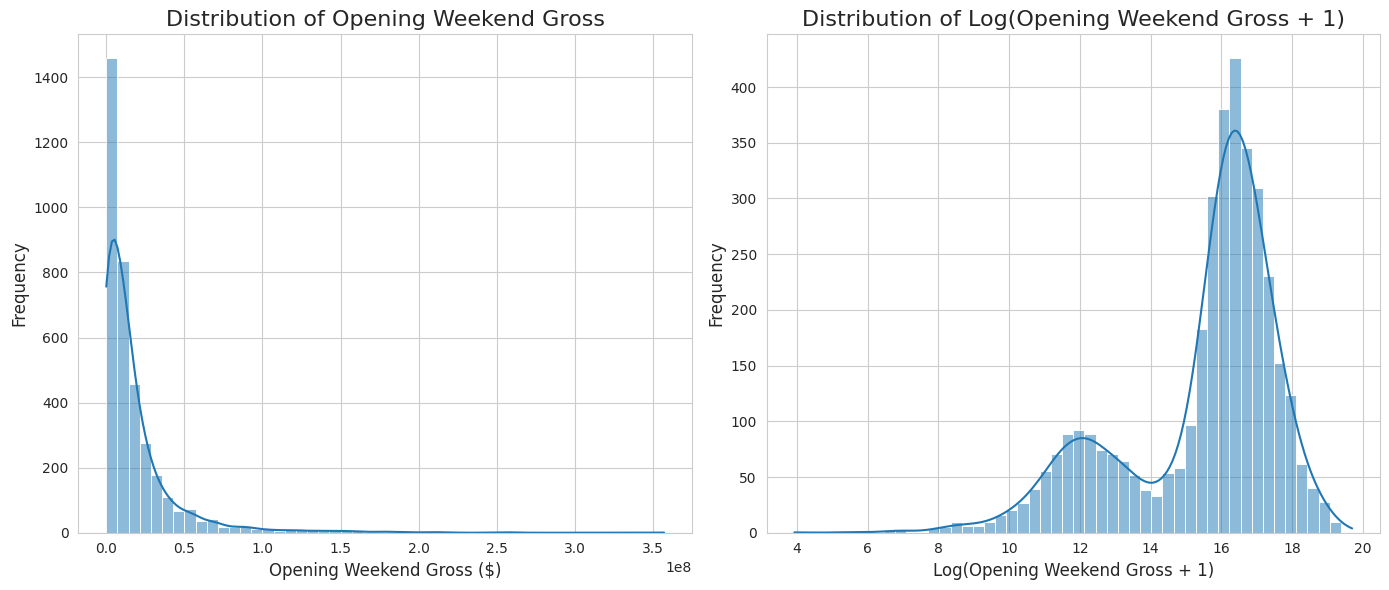

In [ ]:
# Plot distributions of the target variable (original and log-transformed)
plt.figure(figsize=(14, 6))

# Original opening weekend gross
plt.subplot(1, 2, 1)
sns.histplot(df_final_with_synopsis["opening_weekend"], kde=True, bins=50)
plt.title("Distribution of Opening Weekend Gross")
plt.xlabel("Opening Weekend Gross ($)")
plt.ylabel("Frequency")

# Log-transformed opening weekend gross
plt.subplot(1, 2, 2)
sns.histplot(df_final_with_synopsis["opening_weekend_log"], kde=True, bins=50)
plt.title("Distribution of Log(Opening Weekend Gross + 1)")
plt.xlabel("Log(Opening Weekend Gross + 1)")
plt.ylabel("Frequency")

plt.tight_layout()
plt.show()


# Exploring Numerical Features

Numerical features often play a significant role in predictive modeling. To understand their distributions and relationships with the target variable, we:
1. Plot histograms for key numerical features, such as `production_budget_log`, `running_time_cleaned`, and others.
2. Create scatter plots to visualize the relationship between each numerical feature and the log-transformed target variable (`opening_weekend_log`).

These visualizations help us identify trends, correlations, and potential issues like outliers or non-linear relationships.

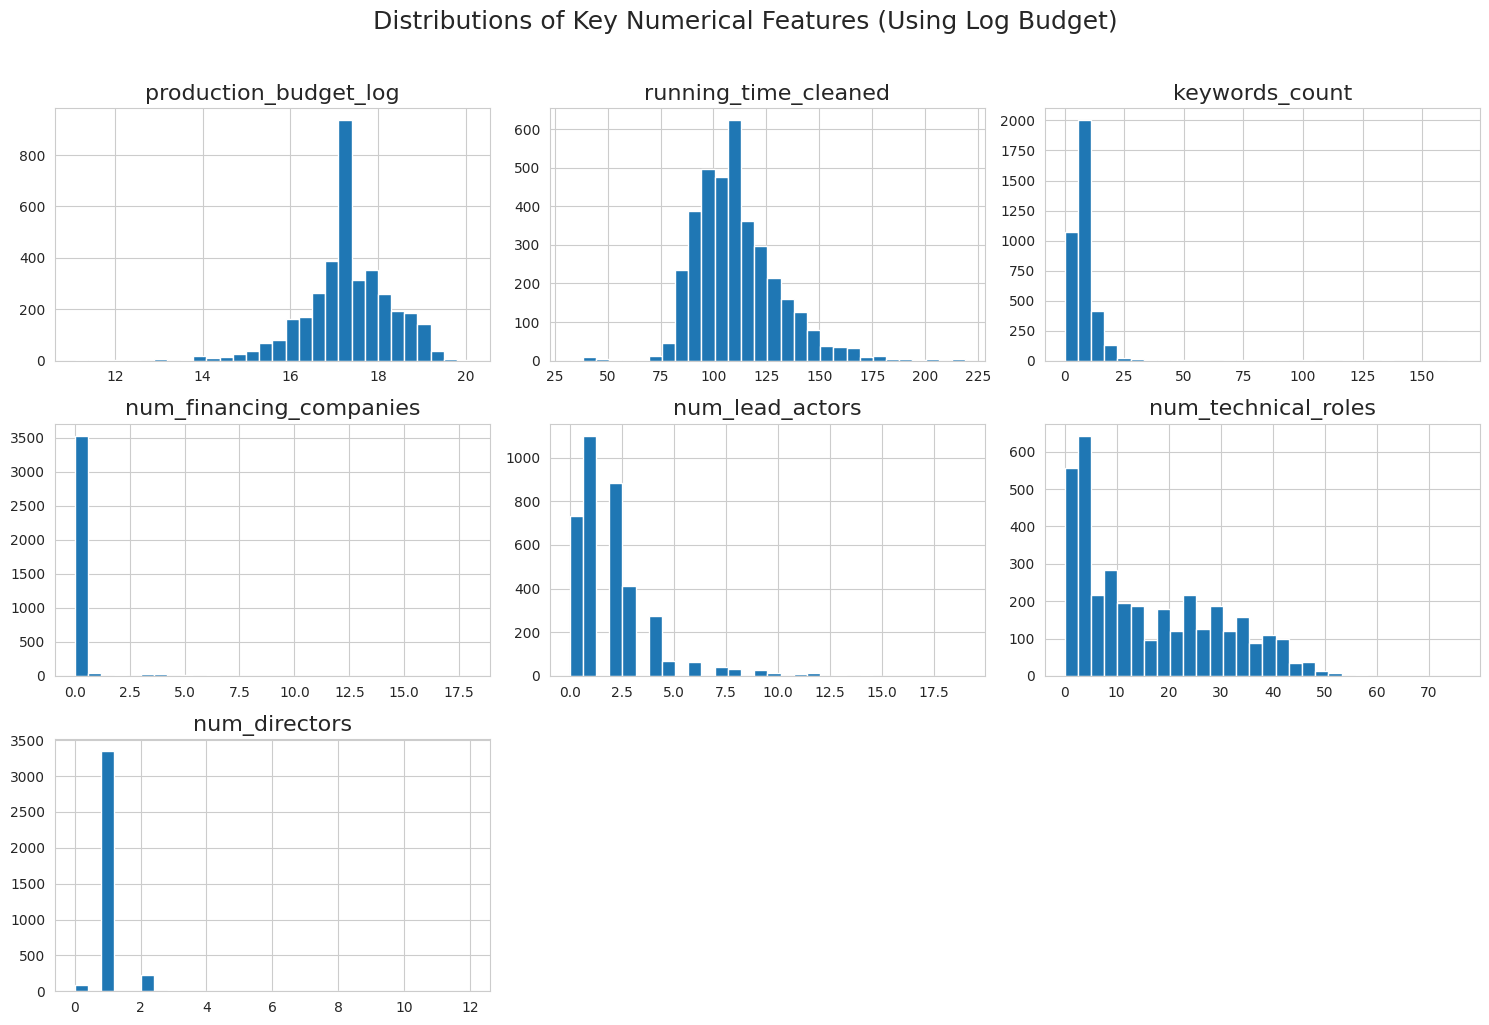

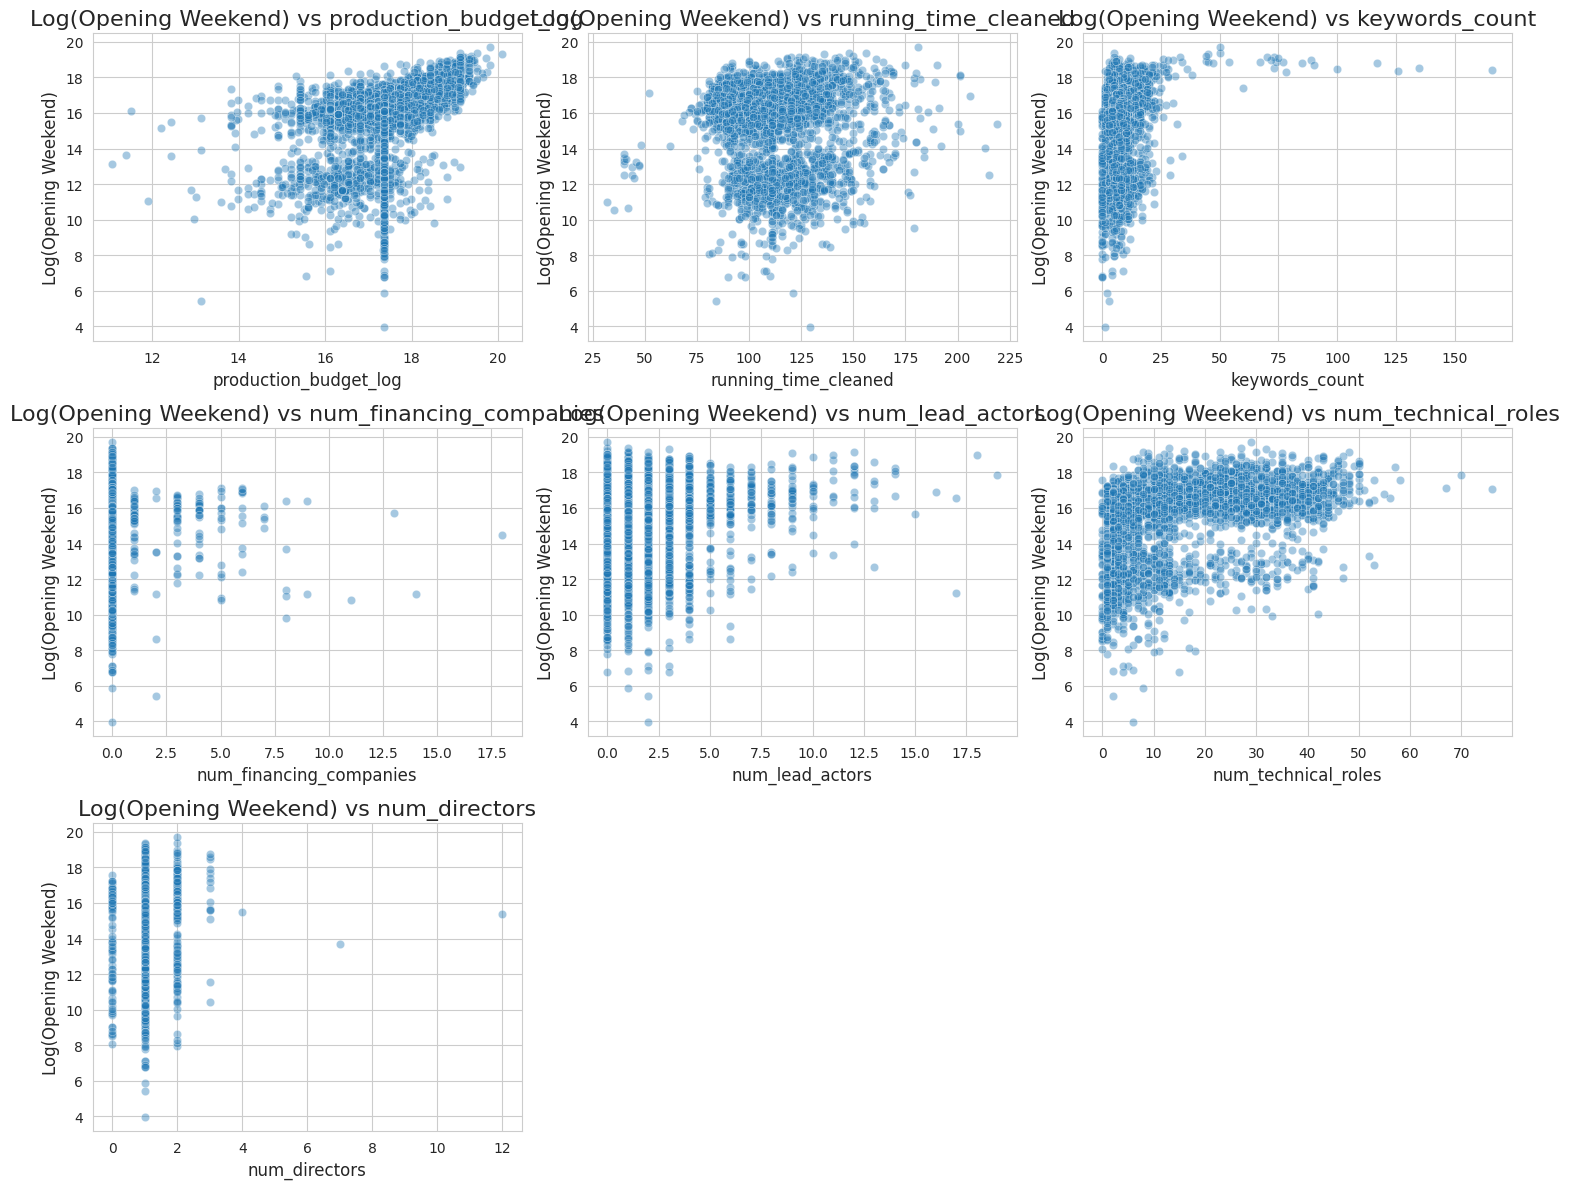

In [ ]:
# Select numerical features to visualize
numerical_features_log = [
    "production_budget_log",
    "running_time_cleaned",
    "keywords_count",
    "num_financing_companies",
    "num_lead_actors",
    "num_technical_roles",
    "num_directors",
]

# Keep only existing columns
numerical_features_log = [
    col for col in numerical_features_log if col in df_final_with_synopsis.columns
]

# Plot histograms of numerical features
df_final_with_synopsis[numerical_features_log].hist(
    bins=30, figsize=(15, 10), layout=(-1, 3)
)
plt.suptitle(
    "Distributions of Key Numerical Features (Using Log Budget)", y=1.02, fontsize=18
)
plt.tight_layout()
plt.show()

# Plot scatter plots of each feature vs log-transformed target
n_features = len(numerical_features_log)
n_cols_scat = 3
n_rows_scat = (n_features + n_cols_scat - 1) // n_cols_scat

plt.figure(figsize=(15, n_rows_scat * 4))
for i, col in enumerate(numerical_features_log):
    plt.subplot(n_rows_scat, n_cols_scat, i + 1)
    sns.scatterplot(
        x=df_final_with_synopsis[col],
        y=df_final_with_synopsis["opening_weekend_log"],
        alpha=0.4,
    )
    plt.title(f"Log(Opening Weekend) vs {col}")
    plt.xlabel(col)
    plt.ylabel("Log(Opening Weekend)")
plt.tight_layout()
plt.show()


# Analyzing Categorical Features

Categorical features, such as `genre` and `production_method`, can provide valuable insights into patterns in the data. In this step, we:
1. Identify the top categories for each categorical feature.
2. Create boxplots to visualize the relationship between the top categories and the log-transformed target variable (`opening_weekend_log`).

This analysis helps us understand how different categories influence the target variable and guides us in feature engineering.

In [ ]:
# Select original categorical features for visualization
original_categoricals_vis = [
    "source",
    "genre",
    "production_method",
    "creative_type",
    "production_countries",
    "languages",
]

# Keep only those columns that exist in df_plot
original_categoricals_vis = [
    col for col in original_categoricals_vis if col in df_plot.columns
]


In [ ]:
def plot_top_n_categorical(df, col_name, target_col, top_n=15):
    """Plot boxplots of the target variable for the top N most frequent categories."""

    # Check if required columns exist
    if col_name not in df.columns or target_col not in df.columns:
        print(
            f"Skipping plot: Column '{col_name}' or '{target_col}' not found in DataFrame."
        )
        return

    plt.figure(figsize=(15, 7))

    # Select top N categories by frequency
    top_categories = df[col_name].value_counts().nlargest(top_n).index
    df_filtered = df[df[col_name].isin(top_categories)]

    # Handle empty filtered DataFrame
    if df_filtered.empty:
        print(
            f"No data found for top {top_n} categories of '{col_name}'. Skipping plot."
        )
        plt.close()
        return

    try:
        # Order categories by median of the target variable
        order = (
            df_filtered.groupby(col_name)[target_col]
            .median()
            .sort_values(ascending=False)
            .index
        )
        sns.boxplot(
            data=df_filtered, x=col_name, y=target_col, order=order, showfliers=False
        )
    except Exception as e:
        print(f"Could not plot '{col_name}'. Error: {e}. Plotting without order.")
        sns.boxplot(data=df_filtered, x=col_name, y=target_col, showfliers=False)

    plt.title(f"{target_col} vs Top {top_n} {col_name}")
    plt.ylabel(target_col)
    plt.xlabel(col_name)
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()


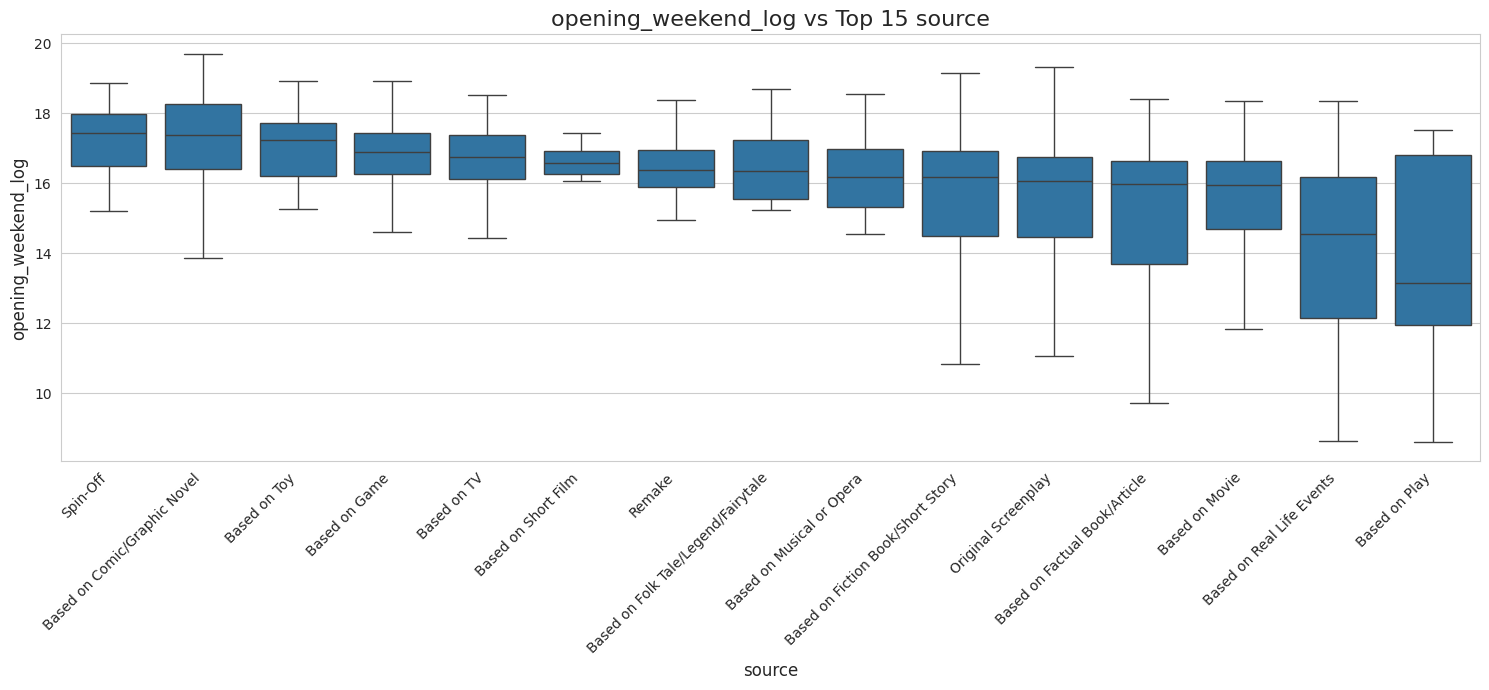

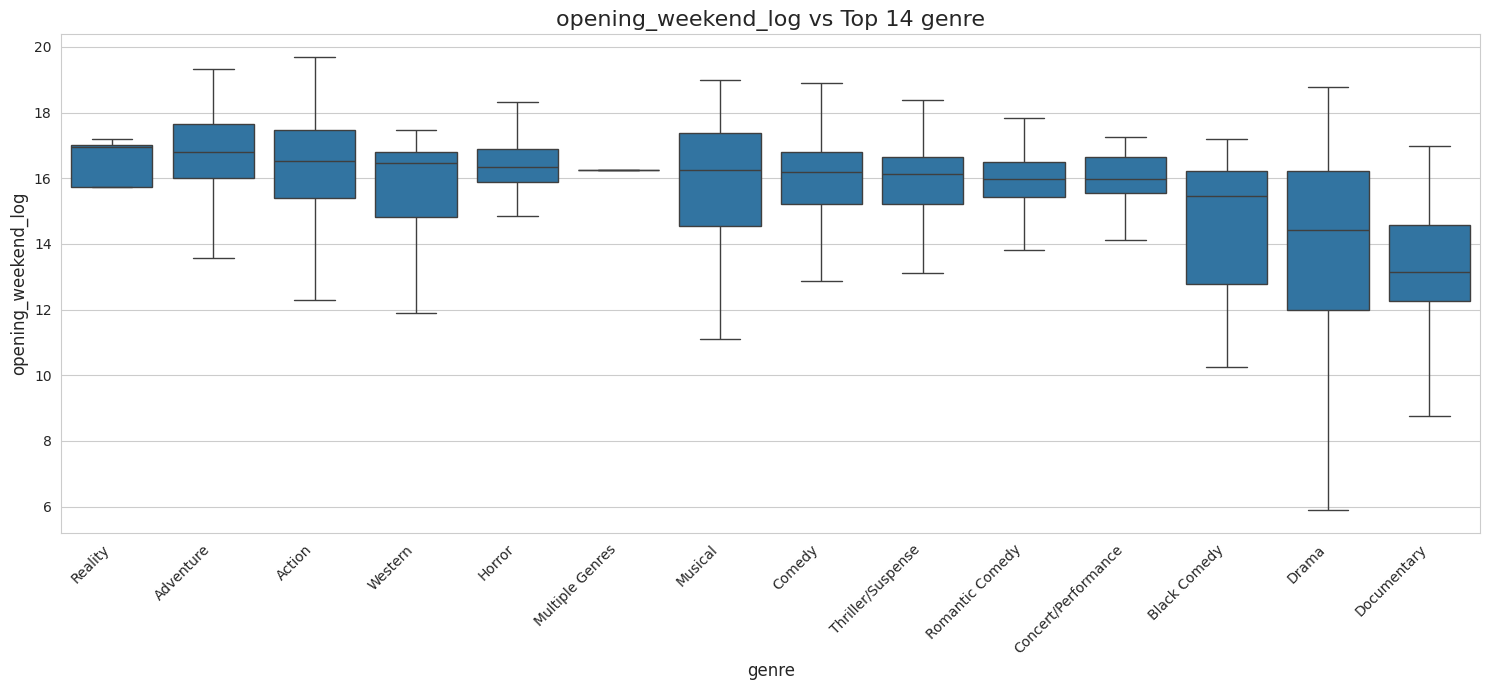

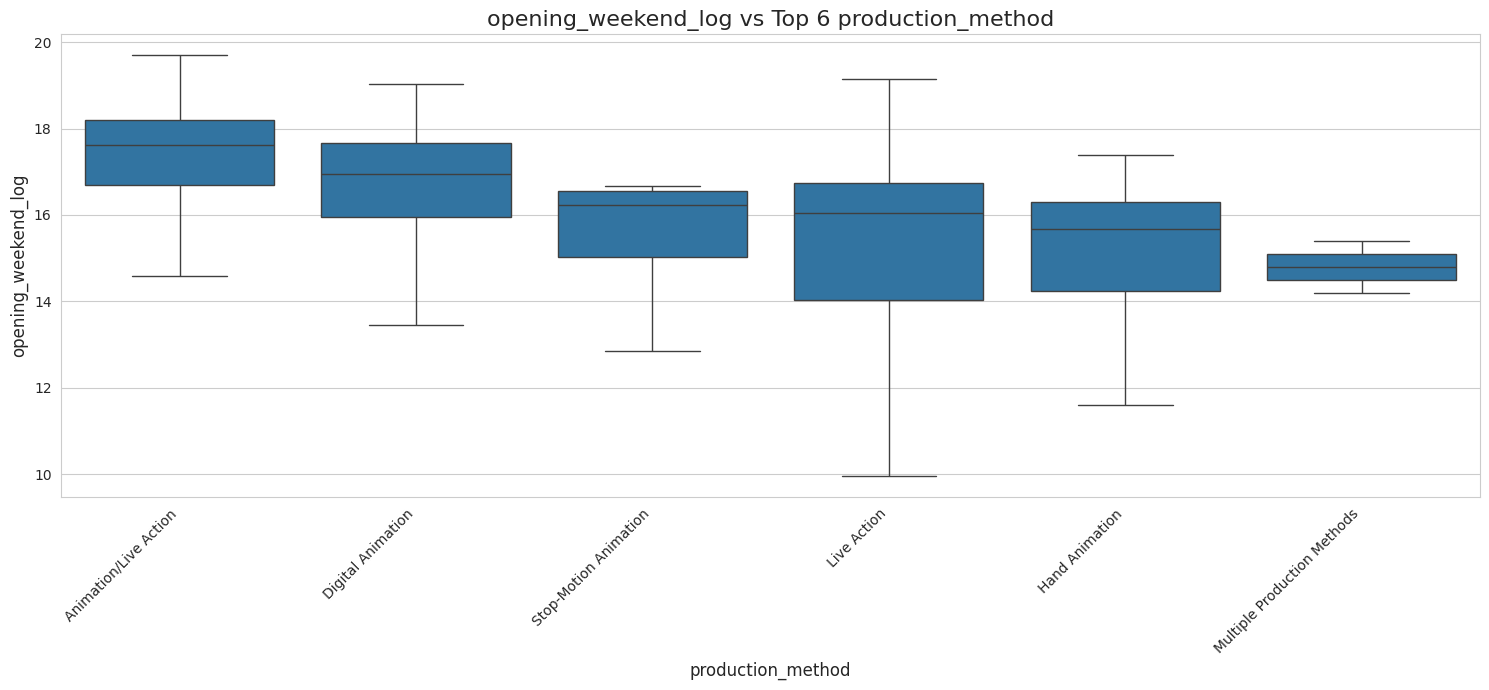

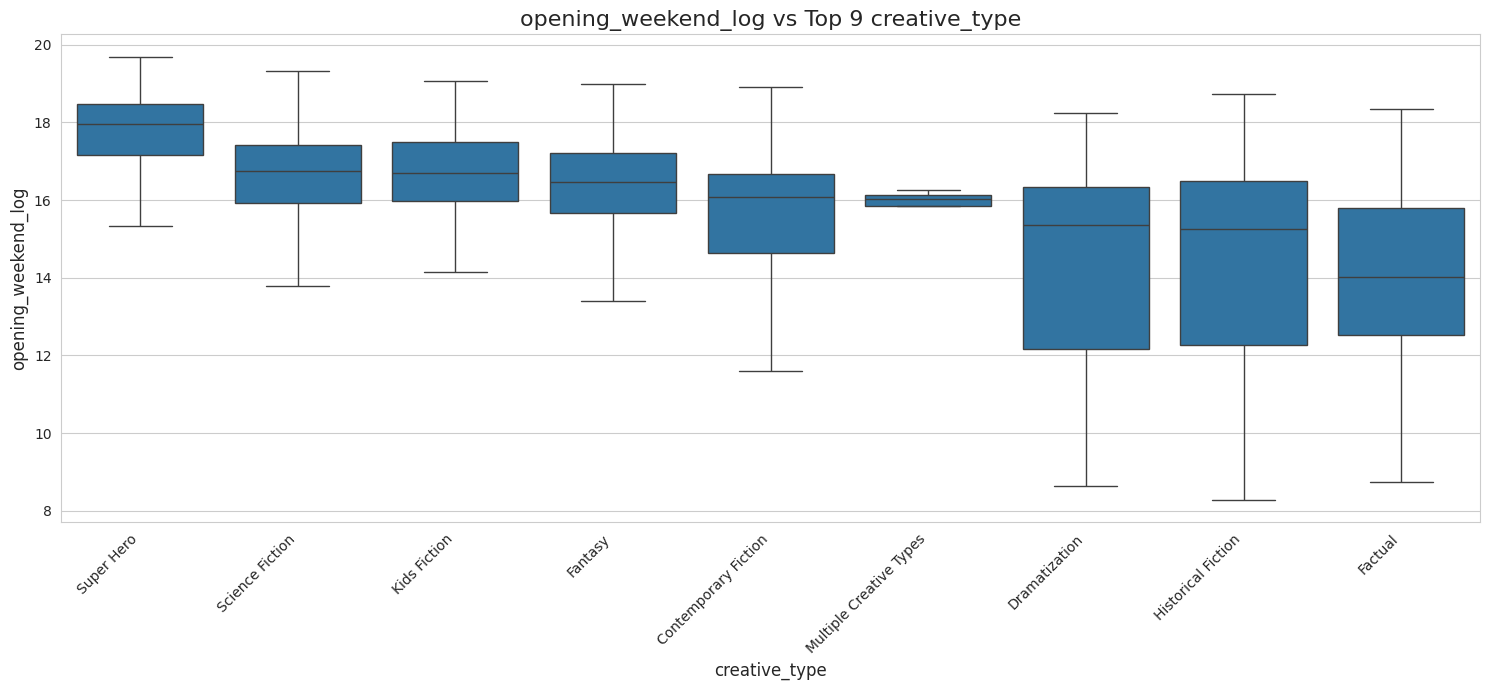

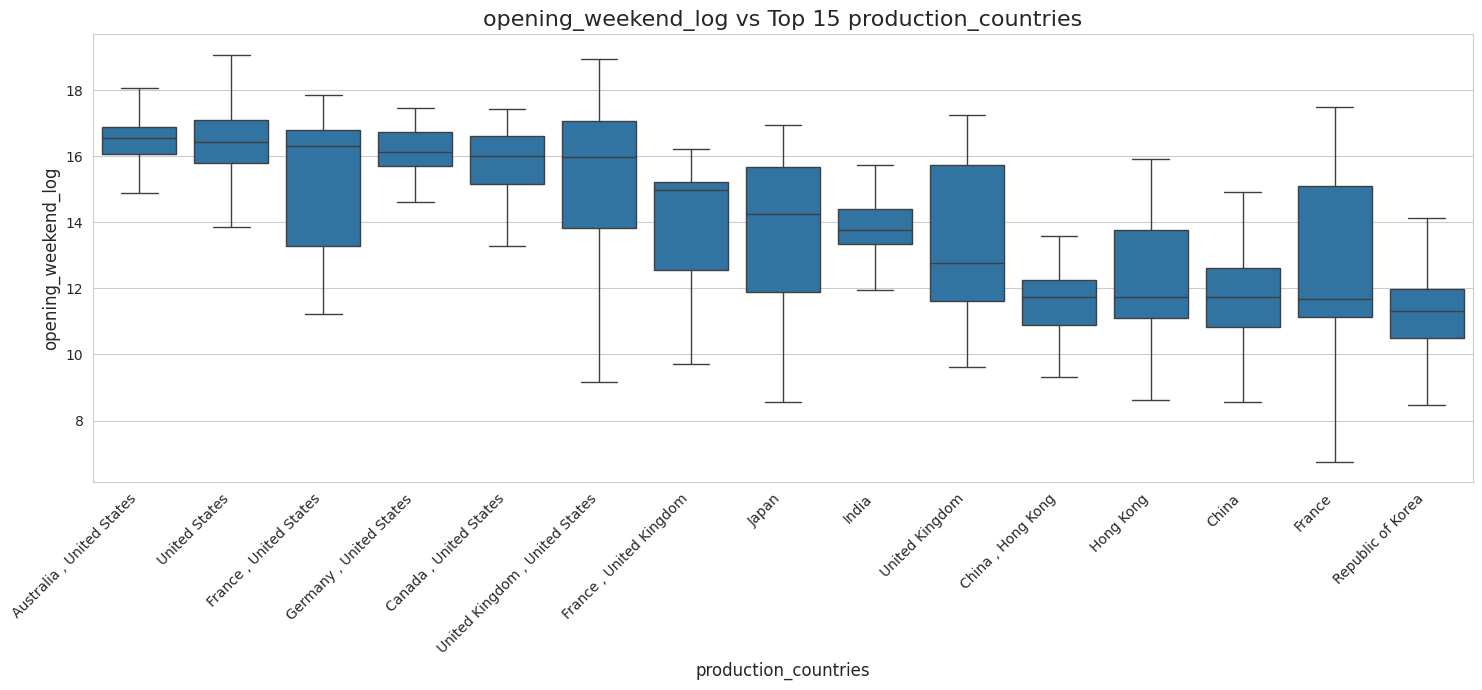

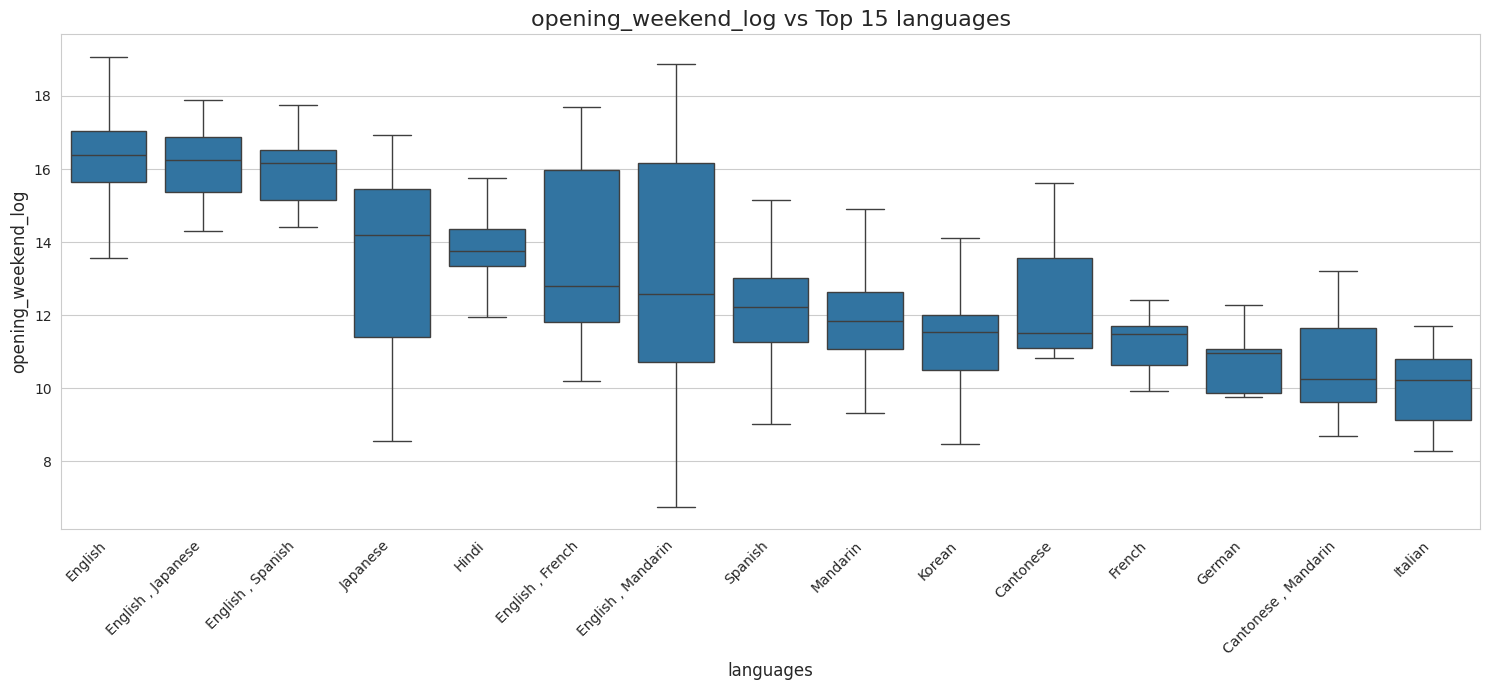

In [ ]:
# Plot boxplots for each original categorical feature against the log-transformed target
for col in original_categoricals_vis:
    n_unique = df_plot[col].nunique()
    plot_top_n_categorical(
        df_plot, col, "opening_weekend_log", top_n=min(n_unique, VIS_TOP_N)
    )


# Time-Based Feature Analysis

Movies are often influenced by their release timing. To uncover temporal patterns, we analyze features such as:
1. Release year: To identify trends over time.
2. Release month: To explore seasonal effects.
3. Day of the week: To understand the impact of weekday vs. weekend releases.

We use line plots and boxplots to visualize these relationships, providing insights into how timing affects opening weekend gross.

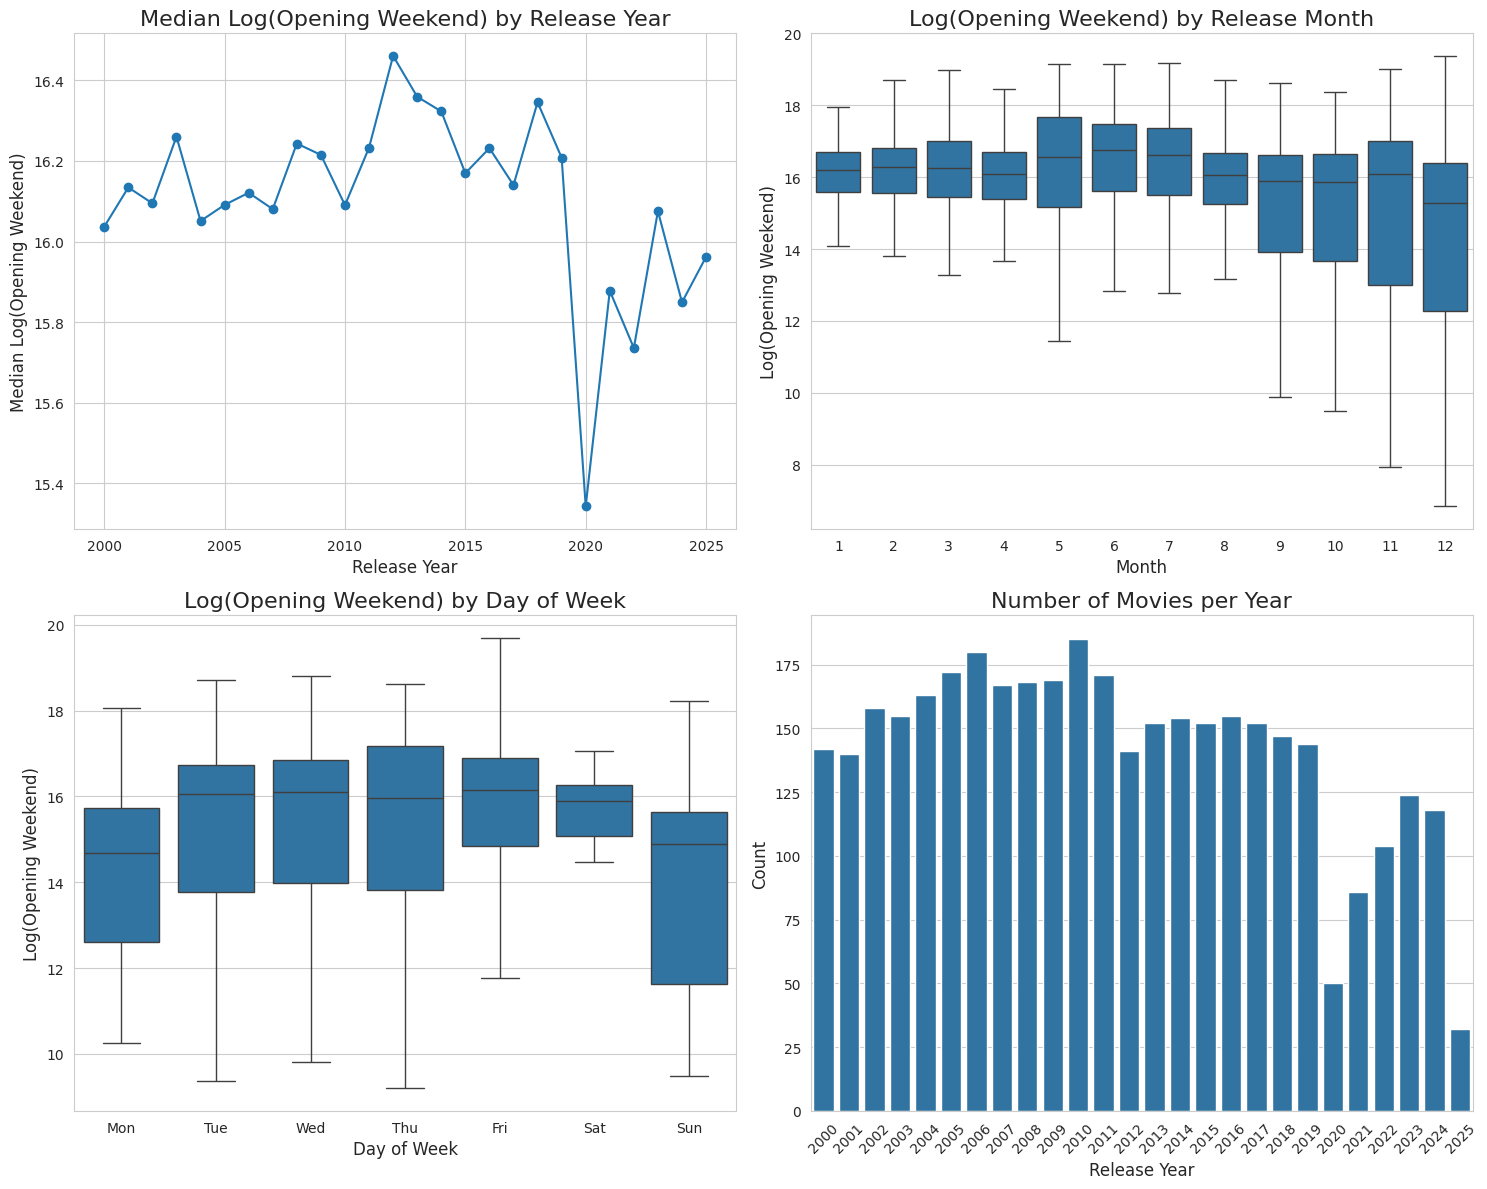

In [ ]:
# Visualize trends and patterns in time-based features
time_cols = ["release_year", "release_month", "release_dayofweek"]

if all(col in df_plot.columns for col in time_cols):
    plt.figure(figsize=(15, 12))

    # Median target value by release year
    plt.subplot(2, 2, 1)
    df_plot.groupby("release_year")["opening_weekend_log"].median().plot(
        kind="line", marker="o"
    )
    plt.title("Median Log(Opening Weekend) by Release Year")
    plt.ylabel("Median Log(Opening Weekend)")
    plt.xlabel("Release Year")
    plt.grid(True)

    # Distribution by release month
    plt.subplot(2, 2, 2)
    sns.boxplot(
        data=df_plot, x="release_month", y="opening_weekend_log", showfliers=False
    )
    plt.title("Log(Opening Weekend) by Release Month")
    plt.xlabel("Month")
    plt.ylabel("Log(Opening Weekend)")

    # Distribution by day of week
    plt.subplot(2, 2, 3)
    day_map = {0: "Mon", 1: "Tue", 2: "Wed", 3: "Thu", 4: "Fri", 5: "Sat", 6: "Sun"}
    df_plot["release_day_name"] = df_plot["release_dayofweek"].map(day_map)
    sns.boxplot(
        data=df_plot,
        x="release_day_name",
        y="opening_weekend_log",
        order=day_map.values(),
        showfliers=False,
    )
    plt.title("Log(Opening Weekend) by Day of Week")
    plt.xlabel("Day of Week")
    plt.ylabel("Log(Opening Weekend)")

    # Count of movie releases per year
    plt.subplot(2, 2, 4)
    sns.countplot(data=df_plot, x="release_year")
    plt.title("Number of Movies per Year")
    plt.xlabel("Release Year")
    plt.ylabel("Count")
    plt.xticks(rotation=45)

    plt.tight_layout()
    plt.show()
else:
    print(
        "Skipping time-based visualization as one or more required columns are missing."
    )


# Correlation Analysis

Understanding the relationships between features and the target variable is crucial for feature selection and engineering. In this step, we:
1. Compute the correlation matrix for numerical features and the log-transformed target variable (`opening_weekend_log`).
2. Visualize the correlation matrix using a heatmap.

This analysis helps us identify strongly correlated features, which can be useful for modeling, and detect multicollinearity, which may require mitigation.

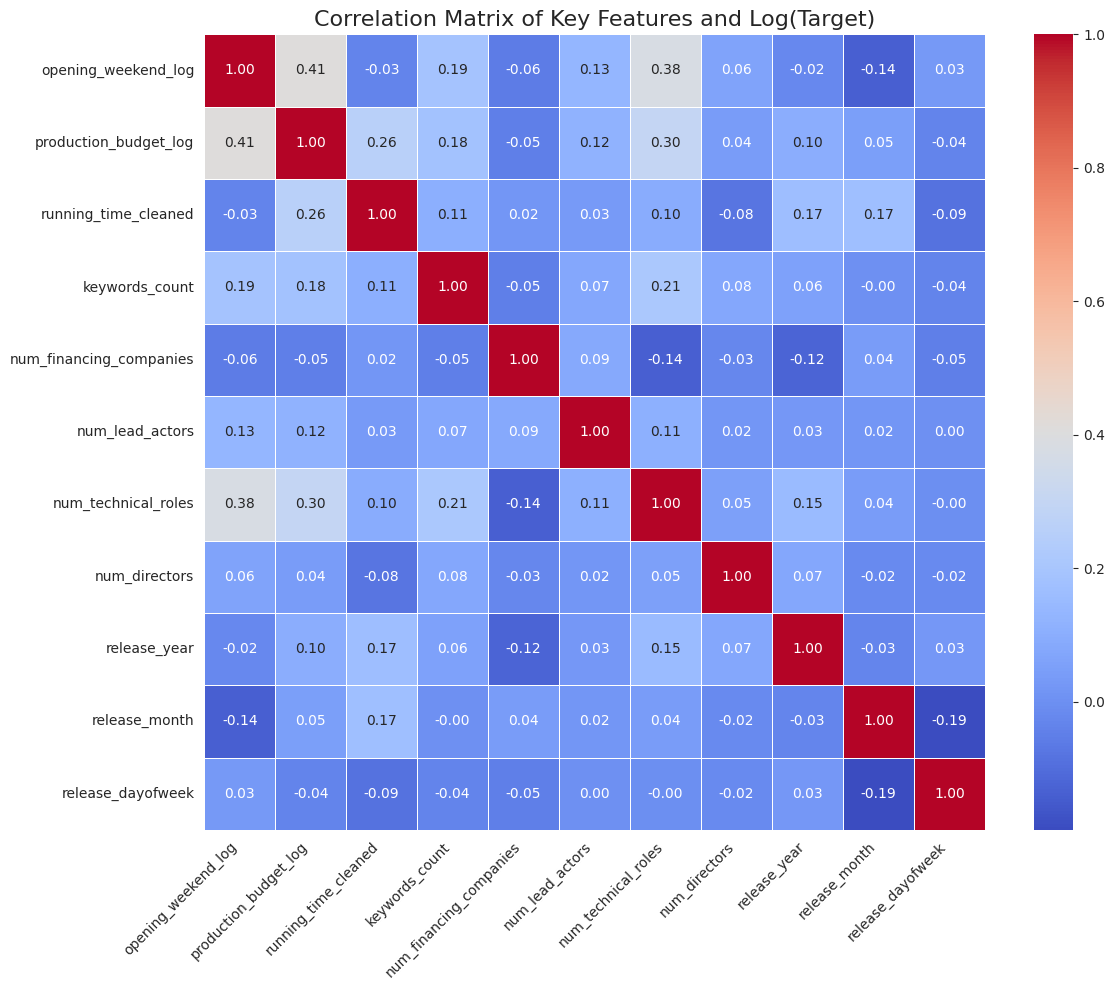

In [ ]:
# Define numeric and count-based features for correlation analysis
cols_for_corr = [
    "opening_weekend_log",
    "production_budget_log",
    "running_time_cleaned",
    "keywords_count",
    "num_financing_companies",
    "num_lead_actors",
    "num_technical_roles",
    "num_directors",
    "release_year",
    "release_month",
    "release_dayofweek",
]

# Ensure only existing columns are included
cols_for_corr = [col for col in cols_for_corr if col in df_final_with_synopsis.columns]

# Plot correlation matrix if enough features are available
if len(cols_for_corr) > 1:
    corr_matrix = df_final_with_synopsis[cols_for_corr].corr()
    plt.figure(figsize=(12, 10))
    sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
    plt.title("Correlation Matrix of Key Features and Log(Target)")
    plt.xticks(rotation=45, ha="right")
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()
else:
    print("Not enough columns available for correlation heatmap.")


# Visualizing Top-N Feature Examples

To understand the impact of specific actors, companies, and roles, we analyze the top-N features created during feature engineering. For example:
1. Binary features indicating the presence of top actors or companies.
2. Role-person pairs, such as directors or producers.

We create boxplots to visualize how the presence of these features influences the log-transformed target variable (`opening_weekend_log`). This step provides insights into the importance of these features in predicting the target variable.

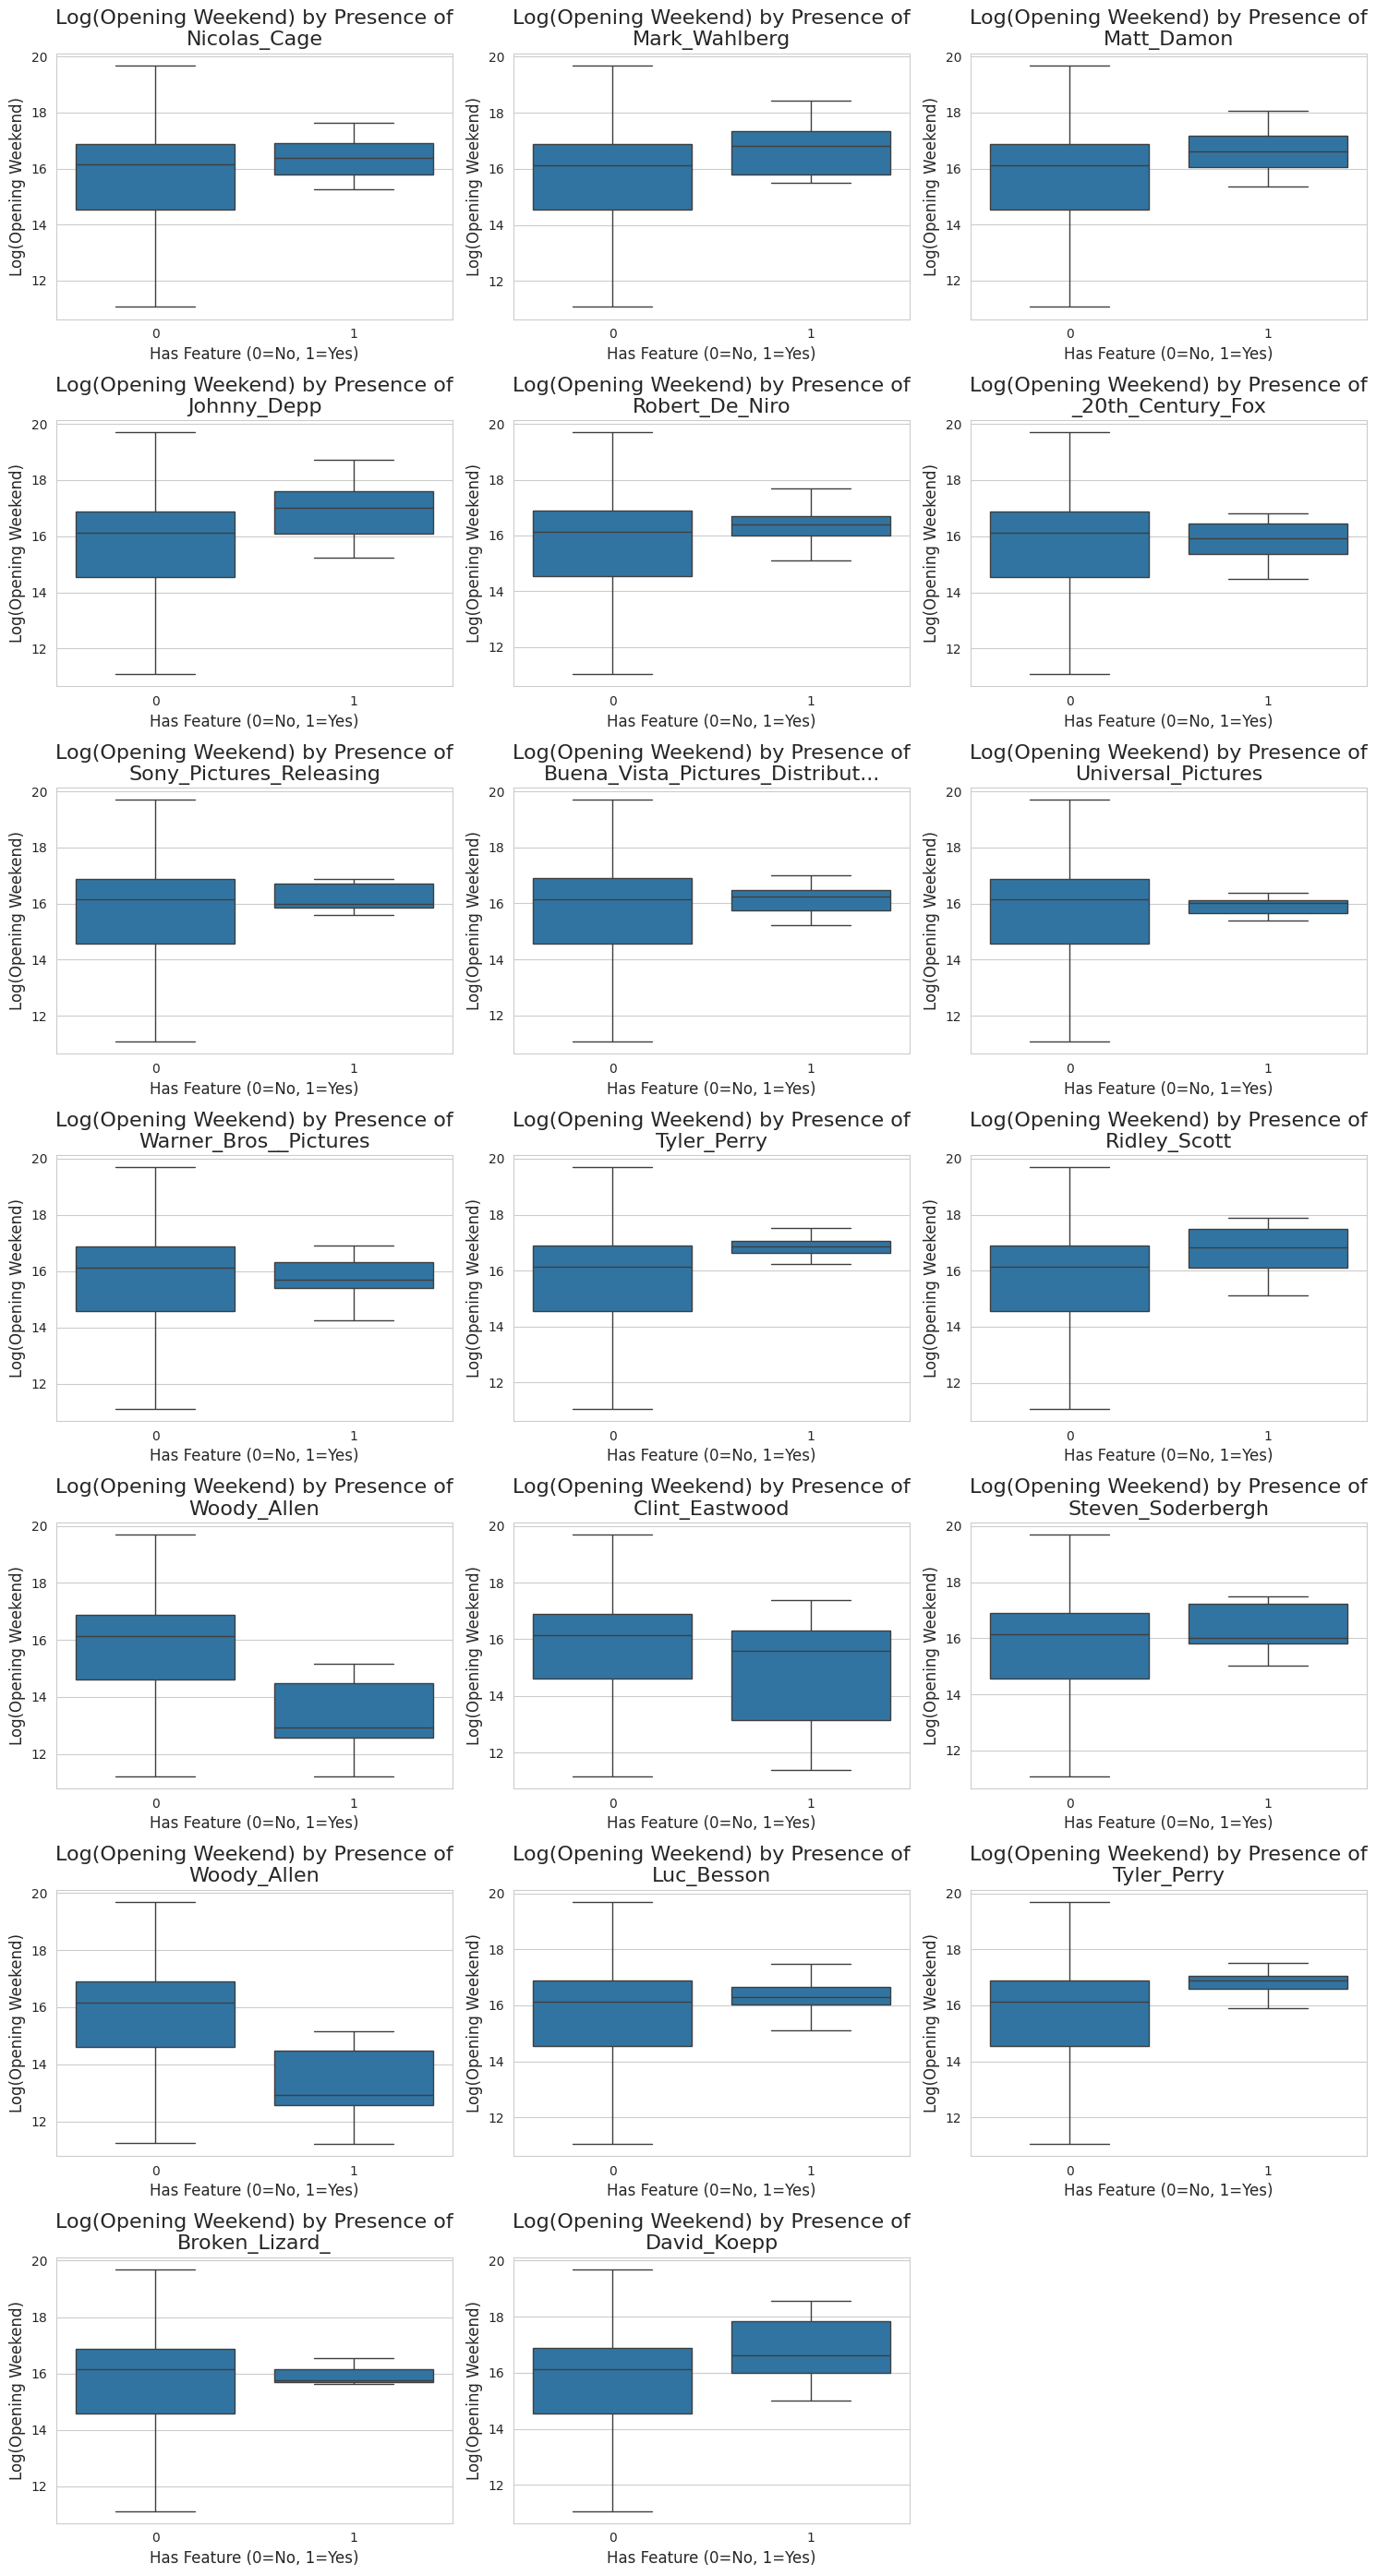

In [ ]:
# Define example feature prefixes for visualization
example_prefixes = ["actor_", "company_"]

# Add example role-based prefixes (using first 2 selected roles)
role_prefixes = [
    f"{re.sub(cleaning_pattern, '_', role)}_" for role in selected_roles[:2]
]
example_prefixes.extend(role_prefixes)

# Collect up to 5 example features per prefix
example_top_n_cols = []
for prefix in example_prefixes:
    cols = [col for col in df_final_with_synopsis.columns if col.startswith(prefix)][:5]
    example_top_n_cols.extend(cols)

# Visualize feature impact using boxplots
if not example_top_n_cols:
    print("Could not find example Top-N columns. Skipping visualization.")
else:
    n_cols_ex = 3
    n_rows_ex = (len(example_top_n_cols) + n_cols_ex - 1) // n_cols_ex
    plt.figure(figsize=(15, n_rows_ex * 4))

    for i, col in enumerate(example_top_n_cols):
        if col in df_final_with_synopsis.columns:
            plt.subplot(n_rows_ex, n_cols_ex, i + 1)
            sns.boxplot(
                data=df_final_with_synopsis,
                x=col,
                y="opening_weekend_log",
                showfliers=False,
            )
            title_part = col.split("_", 1)[1] if "_" in col else col
            plt.title(
                f"Log(Opening Weekend) by Presence of\n{title_part[:30]}{'...' if len(title_part) > 30 else ''}"
            )
            plt.xlabel("Has Feature (0=No, 1=Yes)")
            plt.ylabel("Log(Opening Weekend)")

    plt.tight_layout()
    plt.show()


# Frequency and Unique Count Analysis

To better understand the dataset, we analyze the frequency of top features and count unique entities. Specifically, we:
1. Identify the most frequent actors, companies, and roles in the dataset.
2. Count the number of unique actors and workers per role.

This analysis provides insights into the diversity and distribution of key entities, helping us refine our feature engineering process.


Top 15 Most Frequent Actor Features:
actor_Nicolas_Cage         0.79
actor_Mark_Wahlberg        0.76
actor_Matt_Damon           0.71
actor_Johnny_Depp          0.71
actor_Robert_De_Niro       0.68
actor_Hugh_Jackman         0.68
actor_Tom_Hanks            0.68
actor_Liam_Neeson          0.68
actor_Jason_Statham        0.65
actor_Samuel_L__Jackson    0.62
actor_Denzel_Washington    0.62
actor_Dwayne_Johnson       0.62
actor_Colin_Farrell        0.62
actor_Ryan_Reynolds        0.60
actor_Ben_Affleck          0.57
dtype: float64


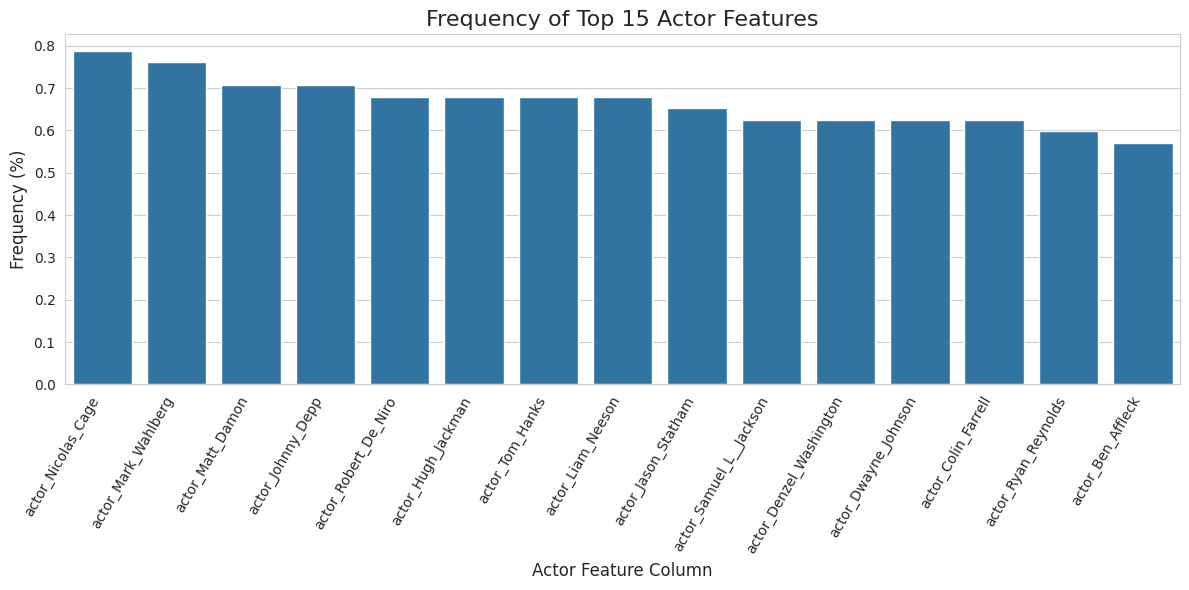


Top 15 Most Frequent Company Features:
company__20th_Century_Fox                    0.41
company_Sony_Pictures_Releasing              0.35
company_Buena_Vista_Pictures_Distribution    0.33
company_Universal_Pictures                   0.24
company_Warner_Bros__Pictures                0.24
company_Eros_International                   0.22
company_Fox_Searchlight_Pictures             0.19
company_Columbia_Pictures                    0.16
company_Miramax_Films                        0.16
company__International_                      0.16
company_Touchstone_Pictures                  0.14
company_UTV_Motion_Pictures                  0.11
company_New_Line_Cinema                      0.11
company_Paramount_Pictures                   0.11
company_Screen_Gems                          0.11
dtype: float64


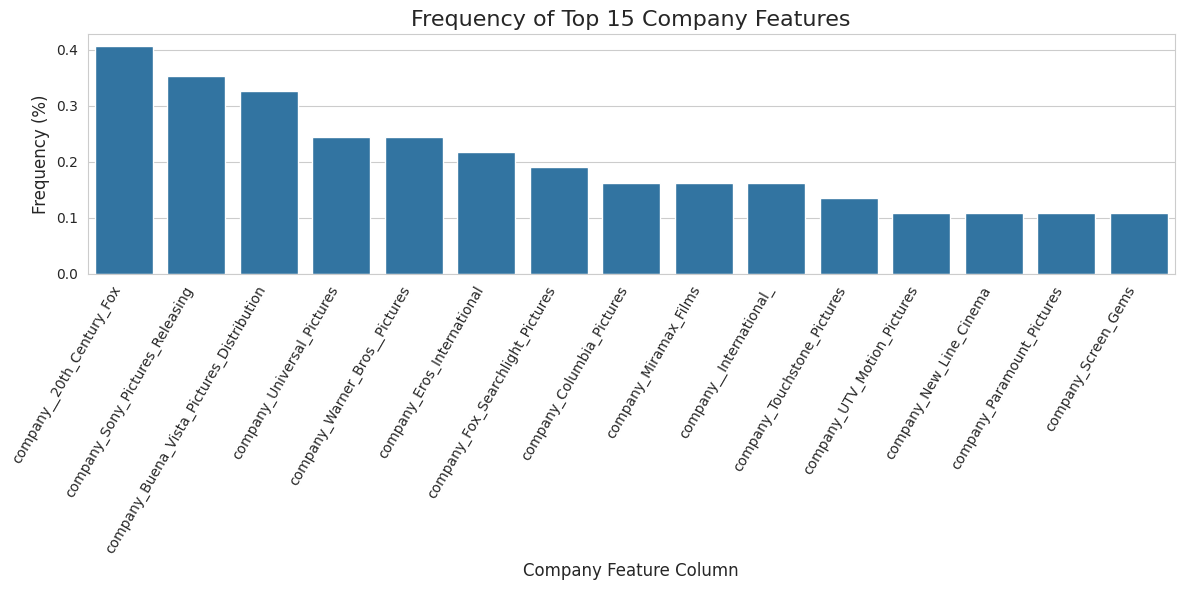


Top 15 Most Frequent Director Features:
Director_Tyler_Perry           0.54
Director_Ridley_Scott          0.52
Director_Woody_Allen           0.49
Director_Clint_Eastwood        0.49
Director_Steven_Soderbergh     0.43
Director_Steven_Spielberg      0.43
Director_M__Night_Shyamalan    0.35
Director_Robert_Rodriguez      0.35
Director_Shawn_Levy            0.35
Director_Guy_Ritchie           0.33
Director_Ron_Howard            0.33
Director_Tim_Burton            0.33
Director_Antoine_Fuqua         0.33
Director_Todd_Phillips         0.30
Director_Peter_Farrelly        0.30
dtype: float64


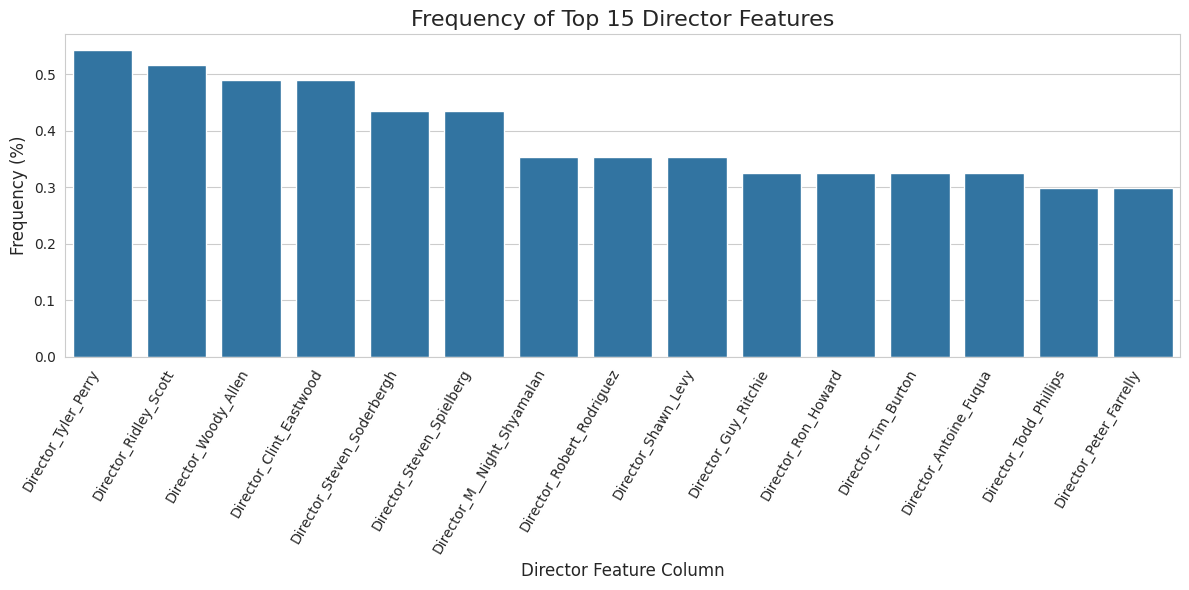


Top 15 Most Frequent Screenwriter Features:
Screenwriter_Woody_Allen              0.49
Screenwriter_Luc_Besson               0.46
Screenwriter_Tyler_Perry              0.43
Screenwriter_David_Koepp              0.38
Screenwriter_Nicholas_Stoller         0.35
Screenwriter_M__Night_Shyamalan       0.35
Screenwriter_John_Logan               0.33
Screenwriter_Joel_Coen                0.33
Screenwriter_Guillermo_del_Toro       0.33
Screenwriter_Chris_Morgan             0.33
Screenwriter_Ethan_Coen               0.30
Screenwriter_Tony_Gilroy              0.30
Screenwriter_Brian_Helgeland          0.30
Screenwriter_Akiva_Goldsman           0.30
Screenwriter_Christopher_McQuarrie    0.30
dtype: float64


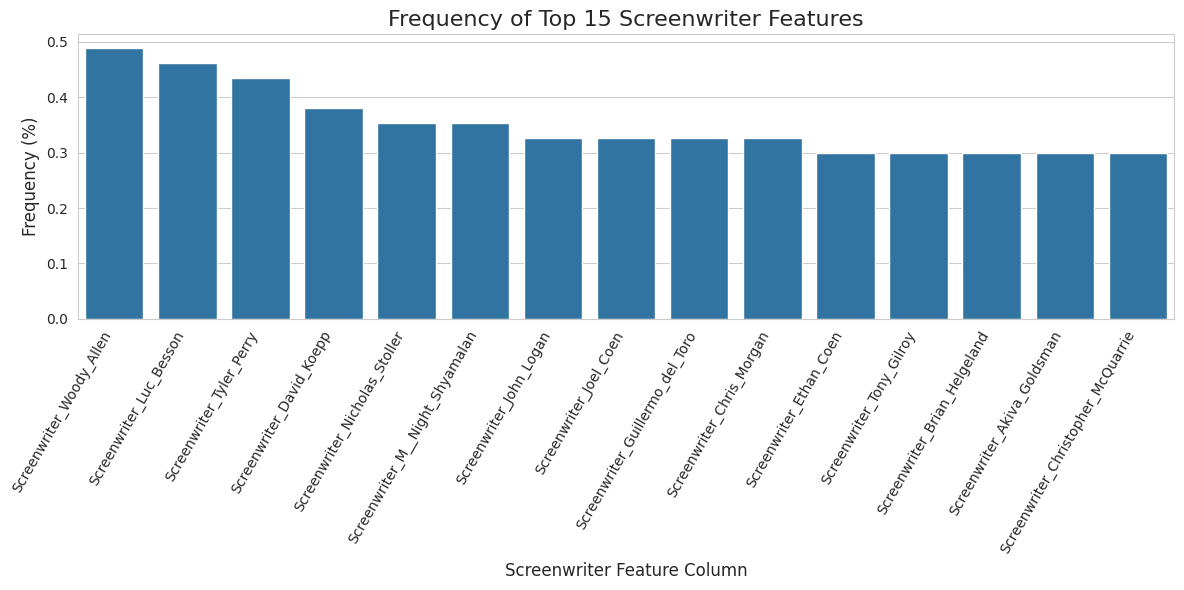

In [ ]:
# Total number of movies in the dataset
num_movies = len(df_final_with_synopsis)

# Analyze frequency of Top-N features by category (e.g., Actor, Company, Roles)
feature_categories = {
    "Actor": "actor_",
    "Company": "company_",
    role_prefixes[0].strip("_"): role_prefixes[0] if len(role_prefixes) > 0 else "",
    role_prefixes[1].strip("_"): role_prefixes[1] if len(role_prefixes) > 1 else "",
}

for category_name, prefix in feature_categories.items():
    if not prefix:
        continue

    # Select columns matching the current prefix
    cols = [col for col in df_final_with_synopsis.columns if col.startswith(prefix)]
    if not cols:
        print(
            f"No columns found for prefix '{prefix}'. Skipping frequency analysis for {category_name}."
        )
        continue

    # Calculate frequency of each feature as a percentage
    freq = (
        df_final_with_synopsis[cols].sum().sort_values(ascending=False)
        / num_movies
        * 100
    )

    print(f"\nTop {VIS_TOP_N} Most Frequent {category_name} Features:")
    print(freq.head(VIS_TOP_N).round(2))

    # Plot bar chart of feature frequencies
    plt.figure(figsize=(12, 6))
    sns.barplot(x=freq.head(VIS_TOP_N).index, y=freq.head(VIS_TOP_N).values)
    plt.title(f"Frequency of Top {VIS_TOP_N} {category_name} Features")
    plt.ylabel("Frequency (%)")
    plt.xlabel(f"{category_name} Feature Column")
    plt.xticks(rotation=60, ha="right")
    plt.tight_layout()
    plt.show()


Top 15 Most Frequent Roles (based on 3681 movies with credits):
Director                    97.77
Screenwriter                87.99
Producer                    74.87
Composer                    67.92
Executive Producer          65.91
Editor                      63.14
Production Designer         56.81
Costume Designer            49.63
Director of Photography     44.50
Casting Director            42.73
Art Director                38.98
Set Decorator               36.81
Supervising Sound Editor    35.29
Re-recording Mixer          35.23
Sound Mixer                 32.06
dtype: float64


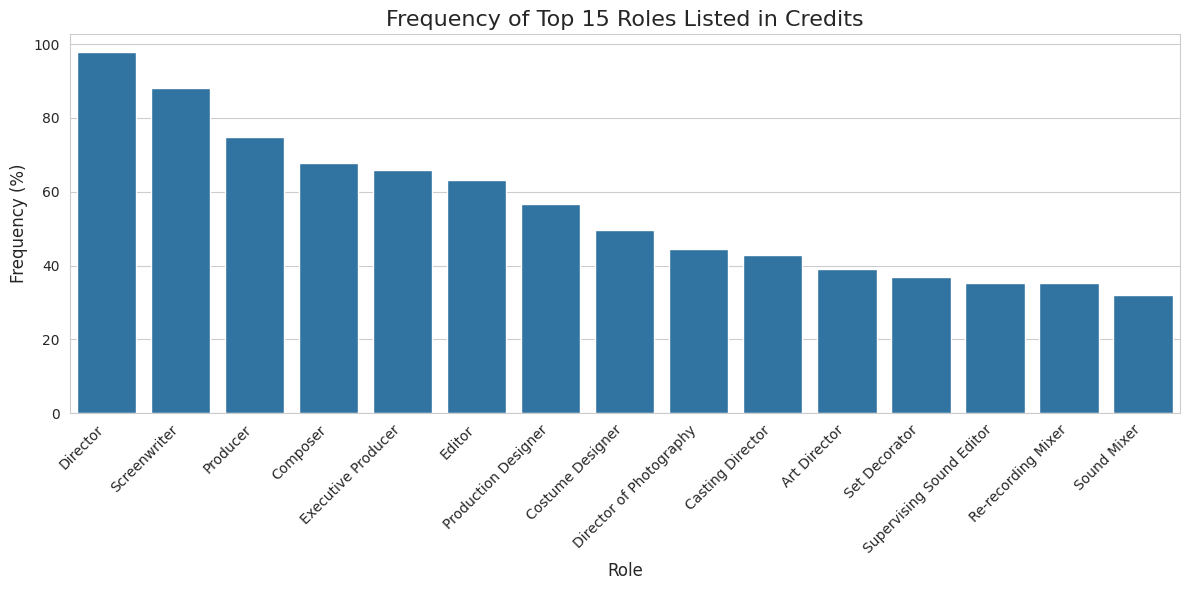

In [ ]:
# Analyze frequency of top roles using original parsed credits
if (
    "parsed_credits_data" in df_aligned.columns
    and not df_aligned["parsed_credits_data"].isnull().all()
):
    all_roles_counter = Counter()
    parsed_credits_valid_freq = df_aligned["parsed_credits_data"].dropna()
    num_valid_credits = len(parsed_credits_valid_freq)

    # Count role occurrences across all valid credit entries
    parsed_credits_valid_freq.apply(
        lambda cred_dict: all_roles_counter.update(
            list(cred_dict.keys()) if isinstance(cred_dict, dict) else []
        )
    )

    if all_roles_counter and num_valid_credits > 0:
        role_counts = pd.Series(all_roles_counter).sort_values(ascending=False)
        role_freq = role_counts / num_valid_credits * 100

        print(
            f"Top {VIS_TOP_N} Most Frequent Roles (based on {num_valid_credits} movies with credits):"
        )
        print(role_freq.head(VIS_TOP_N).round(2))

        # Plot frequency of top roles
        plt.figure(figsize=(12, 6))
        sns.barplot(
            x=role_freq.head(VIS_TOP_N).index, y=role_freq.head(VIS_TOP_N).values
        )
        plt.title(f"Frequency of Top {VIS_TOP_N} Roles Listed in Credits")
        plt.ylabel("Frequency (%)")
        plt.xlabel("Role")
        plt.xticks(rotation=45, ha="right")
        plt.tight_layout()
        plt.show()
    else:
        print("Could not calculate role frequencies.")
else:
    print("Skipping role frequency analysis, parsed credits missing.")


In [ ]:
# Count unique actors from parsed actor data
if (
    "parsed_actors_data" in df_aligned.columns
    and not df_aligned["parsed_actors_data"].isnull().all()
):
    all_unique_actors_set = set()
    for list_of_dicts in df_aligned["parsed_actors_data"].dropna():
        if isinstance(list_of_dicts, list):
            for actor_dict in list_of_dicts:
                if isinstance(actor_dict, dict) and "actor" in actor_dict:
                    actor_name = actor_dict.get("actor")
                    if isinstance(actor_name, str):
                        cleaned_name = actor_name.strip()
                        if cleaned_name:
                            all_unique_actors_set.add(cleaned_name)
    print(f"Total number of unique actors found: {len(all_unique_actors_set)}")
else:
    print("Could not count unique actors.")

# Count unique workers for each role from parsed credits
if (
    "parsed_credits_data" in df_aligned.columns
    and not df_aligned["parsed_credits_data"].isnull().all()
):
    role_unique_workers = defaultdict(set)
    valid_credits_unique = df_aligned["parsed_credits_data"].dropna()

    for credit_dict in valid_credits_unique:
        if isinstance(credit_dict, dict):
            for role, people_list in credit_dict.items():
                role_cleaned = str(role).strip()
                if not role_cleaned:
                    continue
                if isinstance(people_list, list):
                    for person in people_list:
                        person_cleaned = str(person).strip()
                        if person_cleaned:
                            role_unique_workers[role_cleaned].add(person_cleaned)

    if role_unique_workers:
        role_unique_counts = {
            role: len(workers) for role, workers in role_unique_workers.items()
        }
        role_counts_series = pd.Series(role_unique_counts).sort_values(ascending=False)
        print("\nNumber of unique workers found per role (Top 30):")
        print(role_counts_series.head(30))
    else:
        print("Could not count unique workers per role.")
else:
    print("Could not count unique workers per role, parsed credits missing.")


Total number of unique actors found: 2900

Number of unique workers found per role (Top 30):
Executive Producer           4048
Producer                     3153
Screenwriter                 3140
Director                     1835
Co-Producer                  1359
Art Director                 1284
Associate Producer           1054
Editor                       1015
Story Creator                 950
Production Designer           770
Set Designer                  702
Visual Effects Supervisor     678
Composer                      665
Sound Effects Editor          661
Set Decorator                 624
Director of Photography       615
Costume Designer              595
Unit Production Manager       592
Hairstylist                   559
Make up                       556
Stunt Coordinator             552
Assistant Director            534
Sound Mixer                   498
Casting Director              497
Dialogue Editor               496
Costume Supervisor            482
Story by               

# Final Preparation for Modeling

The final step before modeling is to ensure our dataset is ready. We verify that:
1. All features are clean and properly formatted.
2. There are no missing values in the dataset.
3. The dataset contains all the necessary features for modeling.

At the end of this step, we have a fully processed DataFrame (`df_final_with_synopsis`) that is ready for machine learning.

In [ ]:
# Display final shape and a brief summary of the DataFrame
print(
    f"Final DataFrame for modeling ('df_final_with_synopsis') shape: {df_final_with_synopsis.shape}"
)
print("Final DataFrame Info Snippet:")
df_final_with_synopsis.info(verbose=False, max_cols=10)

# Verify total number of missing values
total_nans = df_final_with_synopsis.isnull().sum().sum()
print(f"\nTotal NaN values in final DataFrame: {total_nans}")


Final DataFrame for modeling ('df_final_with_synopsis') shape: (3681, 2271)
Final DataFrame Info Snippet:
<class 'pandas.core.frame.DataFrame'>
Index: 3681 entries, 0 to 4624
Columns: 2271 entries, opening_weekend to production_budget_log
dtypes: bool(407), float64(1005), int64(859)
memory usage: 53.8 MB

Total NaN values in final DataFrame: 0


# Outlier Detection and Removal

Outliers can significantly impact model performance, especially for numerical targets like `opening_weekend`. To address this, we:
1. Use the Interquartile Range (IQR) method to detect outliers in the log-transformed target variable (`opening_weekend_log`).
2. Remove rows with outliers to create a cleaner dataset for modeling.

This step ensures that our model is trained on data that represents the majority of the distribution, improving its generalization ability.

In [ ]:
# Show initial shape before removing outliers
print(f"Original shape before outlier removal: {df_final_with_synopsis.shape}")

# Define the target column to analyze for outliers
TARGET_LOG = "opening_weekend_log"

# Ensure the log-transformed target exists, or compute it if missing
if TARGET_LOG not in df_final_with_synopsis.columns:
    print(f"Error: Target column '{TARGET_LOG}' not found for outlier detection.")
    if "opening_weekend" in df_final_with_synopsis.columns:
        df_final_with_synopsis[TARGET_LOG] = np.log1p(
            df_final_with_synopsis["opening_weekend"]
        )
        print(f"Calculated '{TARGET_LOG}'.")
    else:
        print("Cannot proceed without target variable.")
        exit()

# Calculate interquartile range (IQR) for the target
Q1 = df_final_with_synopsis[TARGET_LOG].quantile(0.25)
Q3 = df_final_with_synopsis[TARGET_LOG].quantile(0.75)
IQR = Q3 - Q1

# Set bounds for outlier removal (standard IQR bounds)
lower_bound = Q1
upper_bound = Q3

print(f"Outlier Detection using IQR for '{TARGET_LOG}':")
print(f"  Q1: {Q1:.4f}")
print(f"  Q3: {Q3:.4f}")
print(f"  IQR: {IQR:.4f}")
print(f"  Lower Bound: {lower_bound:.4f}")
print(f"  Upper Bound: {upper_bound:.4f}")

# Identify rows that are outliers based on bounds
outliers_mask = (df_final_with_synopsis[TARGET_LOG] < lower_bound) | (
    df_final_with_synopsis[TARGET_LOG] > upper_bound
)
num_outliers = outliers_mask.sum()
print(f"\nIdentified {num_outliers} outliers based on '{TARGET_LOG}'.")

# Create a filtered DataFrame excluding outliers
df_filtered = df_final_with_synopsis[~outliers_mask].copy()
print(f"Shape after removing outliers: {df_filtered.shape}")


Original shape before outlier removal: (3681, 2271)
Outlier Detection using IQR for 'opening_weekend_log':
  Q1: 14.5850
  Q3: 16.8885
  IQR: 2.3036
  Lower Bound: 14.5850
  Upper Bound: 16.8885

Identified 1840 outliers based on 'opening_weekend_log'.
Shape after removing outliers: (1841, 2271)


# Preparing Data for Modeling

After removing outliers, we prepare the dataset for modeling by:
1. Splitting the data into training and testing sets.
2. Sanitizing feature names to ensure compatibility with machine learning libraries like XGBoost and LightGBM.

This step ensures that the data is clean, well-structured, and ready for model training and evaluation.

In [ ]:
TARGET_ORIGINAL = "opening_weekend"  # Needed for evaluation on original scale

try:
    # Ensure target columns exist
    if (
        TARGET_LOG not in df_filtered.columns
        or TARGET_ORIGINAL not in df_filtered.columns
    ):
        raise KeyError("Target columns missing after filtering.")

    # Separate features and target
    X = df_filtered.drop([TARGET_LOG, TARGET_ORIGINAL], axis=1)
    y = df_filtered[TARGET_LOG]
    y_original = df_filtered[TARGET_ORIGINAL]

    # Sanitize feature names for compatibility with XGBoost/LightGBM
    print("Sanitizing feature names...")
    original_columns = X.columns
    X.columns = [re.sub(r'[\[\]{}:",]', "_", col) for col in X.columns]
    changed_cols_count = sum(
        1 for oc, nc in zip(original_columns, X.columns) if oc != nc
    )
    print(f"Sanitized {changed_cols_count} column names.")

    print(f"Features shape (filtered): {X.shape}")
    print(f"Target shape (filtered): {y.shape}")

except KeyError as e:
    print(f"Error separating features/target after filtering: Missing column {e}")
    exit()
except Exception as e:
    print(f"An unexpected error occurred during data preparation after filtering: {e}")
    exit()

# Train-test split on filtered dataset
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Match original scale target values for test set evaluation
y_test_original = y_original.loc[y_test.index]

print(f"Training set shape (filtered): X={X_train.shape}, y={y_train.shape}")
print(f"Testing set shape (filtered): X={X_test.shape}, y={y_test.shape}")


Sanitizing feature names...
Sanitized 305 column names.
Features shape (filtered): (1841, 2269)
Target shape (filtered): (1841,)
Training set shape (filtered): X=(1472, 2269), y=(1472,)
Testing set shape (filtered): X=(369, 2269), y=(369,)


# Training XGBoost on Filtered Data

XGBoost is a powerful gradient boosting algorithm that performs well on structured data. In this step, we:
1. Train an XGBoost model on the filtered training data.
2. Evaluate its performance on the test set using metrics such as R-squared, RMSE, and MAE.

This step provides a baseline for model performance and helps us identify areas for improvement.

In [ ]:
# --- Define MdAPE function ---
def median_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.asarray(y_true), np.asarray(y_pred)
    epsilon = 1e-8
    valid_idx = np.where(np.abs(y_true) > epsilon)[0]
    if len(valid_idx) == 0:
        return np.nan
    y_true_filt = y_true[valid_idx]
    y_pred_filt = y_pred[valid_idx]
    valid_pred_idx = np.where(~np.isnan(y_pred_filt))[0]
    y_true_filt = y_true_filt[valid_pred_idx]
    y_pred_filt = y_pred_filt[valid_pred_idx]
    if len(y_true_filt) == 0:
        return np.nan
    return np.median(np.abs((y_true_filt - y_pred_filt) / y_true_filt)) * 100


In [ ]:
# Define XGBoost pipeline with predefined hyperparameters
pipe_xgb = Pipeline(
    [
        (
            "model",
            xgb.XGBRegressor(
                objective="reg:squarederror",
                device="cuda",
                tree_method="hist",
                n_estimators=300,
                learning_rate=0.05,
                max_depth=5,
                subsample=0.8,
                colsample_bytree=0.7,
                random_state=42,
            ),
        )
    ]
)

# Train the model and time the process
print("Training XGBoost on filtered data...")
start_time = time.time()
pipe_xgb.fit(X_train, y_train)
end_time = time.time()
print(f"Training finished in {end_time - start_time:.2f} seconds.")


Training XGBoost on filtered data...
Training finished in 2.99 seconds.


In [ ]:
# Predict on test data (log scale)
y_pred_log = pipe_xgb.predict(X_test)

# Evaluate on log-transformed target
r2_log = r2_score(y_test, y_pred_log)
rmse_log = np.sqrt(mean_squared_error(y_test, y_pred_log))
mae_log = mean_absolute_error(y_test, y_pred_log)

print("Test Set Performance (XGBoost - Log Scale - Filtered Data):")
print(f"  R-squared: {r2_log:.4f}")
print(f"  RMSE:      {rmse_log:.4f}")
print(f"  MAE:       {mae_log:.4f}")

# Convert predictions back to original scale
y_pred_original = np.expm1(y_pred_log)
y_pred_original[y_pred_original < 0] = 0
y_test_original_np = y_test_original.values

# Evaluate on original scale (absolute error)
r2_orig = r2_score(y_test_original_np, y_pred_original)
rmse_orig = np.sqrt(mean_squared_error(y_test_original_np, y_pred_original))
mae_orig = mean_absolute_error(y_test_original_np, y_pred_original)

print("Test Set Performance (XGBoost - Original Scale - Absolute - Filtered Data):")
print(f"  R-squared: {r2_orig:.4f}")
print(f"  RMSE:      ${rmse_orig:,.0f}")
print(f"  MAE:       ${mae_orig:,.0f}")

# Filter test set for percentage-based error metrics
valid_perc_error_idx = np.where(np.abs(y_test_original_np) > 100)[0]
print(
    f"  Calculating percentage errors using {len(valid_perc_error_idx)} samples where abs(actual) > 100."
)

if len(valid_perc_error_idx) > 0:
    y_test_filt = y_test_original_np[valid_perc_error_idx]
    y_pred_filt = y_pred_original[valid_perc_error_idx]
    y_pred_filt = np.nan_to_num(
        y_pred_filt, nan=0.0, posinf=y_test_filt.max() * 10, neginf=0.0
    )
    mape_orig = mean_absolute_percentage_error(y_test_filt, y_pred_filt) * 100
    mdape_orig = median_absolute_percentage_error(y_test_filt, y_pred_filt)
else:
    mape_orig, mdape_orig = np.nan, np.nan

print("Test Set Performance (XGBoost - Original Scale - Relative - Filtered Data):")
print(f"  MAPE:      {mape_orig:.2f}%")
print(f"  MdAPE:     {mdape_orig:.2f}%")


Test Set Performance (XGBoost - Log Scale - Filtered Data):
  R-squared: 0.1872
  RMSE:      0.4863
  MAE:       0.3975
Test Set Performance (XGBoost - Original Scale - Absolute - Filtered Data):
  R-squared: 0.1185
  RMSE:      $4,870,161
  MAE:       $3,955,707
  Calculating percentage errors using 369 samples where abs(actual) > 100.
Test Set Performance (XGBoost - Original Scale - Relative - Filtered Data):
  MAPE:      44.10%
  MdAPE:     34.06%


# Clustering for Enhanced Modeling

To capture unique patterns within subsets of the data, we use clustering. The idea is to:
1. Group movies into clusters based on features like budget, runtime, and release year.
2. Train separate models for each cluster, tailoring predictions to the specific characteristics of each group.

This approach allows us to improve model performance by leveraging the heterogeneity in the dataset.

In [223]:
TARGET = "opening_weekend_log"
TARGET_ORIGINAL = "opening_weekend"

# Check for required target columns
if TARGET not in df_filtered.columns or TARGET_ORIGINAL not in df_filtered.columns:
    print("Error: Target columns missing!")
    exit()

# Separate features and targets
X_full_orig = df_filtered.drop([TARGET, TARGET_ORIGINAL], axis=1)
y_full = df_filtered[TARGET]
y_original_full = df_filtered[TARGET_ORIGINAL]

# Sanitize feature names for compatibility with XGBoost/LightGBM
print("Sanitizing feature names...")
X_full = X_full_orig.copy()
original_columns = X_full.columns
X_full.columns = [re.sub(r'[\[\]{}:",]', "_", col) for col in X_full.columns]

changed_cols_count = sum(
    1 for oc, nc in zip(original_columns, X_full.columns) if oc != nc
)
print(f"Sanitized {changed_cols_count} column names.")
print(f"Full features shape: {X_full.shape}")


Sanitizing feature names...
Sanitized 305 column names.
Full features shape: (1841, 2269)


In [224]:
# Select relevant features for clustering
cols_for_clustering = [
    "production_budget_cleaned",
    "running_time_cleaned",
    "keywords_count",
    "num_financing_companies",
    "num_lead_actors",
    "num_technical_roles",
    "num_directors",
    "release_year",
]

# Ensure only columns that exist after sanitization are included
cols_for_clustering = [col for col in cols_for_clustering if col in X_full.columns]

if not cols_for_clustering:
    print("Error: No suitable columns found for clustering!")
    exit()

print(f"Using columns for clustering: {cols_for_clustering}")

# Prepare features for clustering
X_cluster_features = X_full[cols_for_clustering].copy()

# Impute missing values with median
for col in X_cluster_features.columns:
    if X_cluster_features[col].isnull().any():
        median_val = X_cluster_features[col].median()
        X_cluster_features[col].fillna(median_val, inplace=True)

# Scale features
cluster_scaler = StandardScaler()
X_clust_scaled = cluster_scaler.fit_transform(X_cluster_features)

print("Features for clustering scaled.")


Using columns for clustering: ['production_budget_cleaned', 'running_time_cleaned', 'keywords_count', 'num_financing_companies', 'num_lead_actors', 'num_technical_roles', 'num_directors', 'release_year']
Features for clustering scaled.


In [225]:
# Perform KMeans clustering using predefined optimal K
OPTIMAL_K = 4
print(f"Using predefined K = {OPTIMAL_K} for clustering.")

kmeans_final = KMeans(n_clusters=OPTIMAL_K, random_state=42, n_init=10)
cluster_labels = kmeans_final.fit_predict(X_clust_scaled)

# Add cluster labels to the main feature DataFrame
X_full["Cluster"] = cluster_labels
print("Cluster labels added to main feature DataFrame 'X_full'.")
print("Cluster sizes:\n", X_full["Cluster"].value_counts().sort_index())


Using predefined K = 4 for clustering.
Cluster labels added to main feature DataFrame 'X_full'.
Cluster sizes:
 Cluster
0    287
1    821
2     61
3    672
Name: count, dtype: int64


In [226]:
# Split full data (with cluster labels) into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X_full,
    y_full,
    test_size=0.2,
    random_state=42,  # Stratification by both cluster and target is not applied
)

# Retrieve original scale target values for evaluation
y_train_original = y_original_full.loc[y_train.index]
y_test_original = y_original_full.loc[y_test.index]

print(f"Training set shape: X={X_train.shape}, y={y_train.shape}")
print(f"Testing set shape: X={X_test.shape}, y={y_test.shape}")


Training set shape: X=(1472, 2270), y=(1472,)
Testing set shape: X=(369, 2270), y=(369,)


In [227]:
# Define candidate models and corresponding parameter grids for grid search
candidate_pipelines = {}
candidate_param_grids = {}

# Ridge Regression pipeline and parameters
pipe_ridge = Pipeline([("scaler", StandardScaler()), ("model", Ridge(random_state=42))])
candidate_pipelines["Ridge"] = pipe_ridge
candidate_param_grids["Ridge"] = {"model__alpha": [10.0, 100.0, 500.0, 1000.0]}

# Random Forest pipeline and parameters
pipe_rf = Pipeline([("model", RandomForestRegressor(random_state=42, n_jobs=-1))])
candidate_pipelines["RandomForest"] = pipe_rf
candidate_param_grids["RandomForest"] = {
    "model__n_estimators": [100, 250],
    "model__max_depth": [15, 25, None],
    "model__min_samples_leaf": [5, 10],
    "model__max_features": ["sqrt", 0.5],
}

# XGBoost pipeline and parameters
pipe_xgb = Pipeline(
    [
        (
            "model",
            xgb.XGBRegressor(
                objective="reg:squarederror",
                device="cuda",
                tree_method="hist",
                random_state=42,
                subsample=0.8,
                colsample_bytree=0.7,
            ),
        )
    ]
)
candidate_pipelines["XGBoost"] = pipe_xgb
candidate_param_grids["XGBoost"] = {
    "model__n_estimators": [100, 300],
    "model__learning_rate": [0.1, 0.05],
    "model__max_depth": [6, 8],
}

# Combine model pipelines and param grids into format expected by GridSearchCV
param_grid_list = [
    {**{"model": [pipe_ridge]}, **candidate_param_grids["Ridge"]},
    {**{"model": [pipe_rf]}, **candidate_param_grids["RandomForest"]},
    {**{"model": [pipe_xgb]}, **candidate_param_grids["XGBoost"]},
]


In [230]:
# Store best models and selection metadata for each cluster
best_cluster_models = {}
cluster_selection_results = {}

# K-Fold cross-validation for tuning within each cluster
inner_cv = KFold(n_splits=3, shuffle=True, random_state=42)
unique_clusters_train = sorted(X_train["Cluster"].unique())

print(f"Selecting and training models for clusters: {unique_clusters_train}")

MIN_SAMPLES_FOR_CV = 10  # Minimum samples required for reliable CV

for cluster_id in unique_clusters_train:
    print(f"\n===== Processing Cluster {cluster_id} =====")

    # Filter training data for the current cluster
    X_train_cluster = X_train[X_train["Cluster"] == cluster_id].drop("Cluster", axis=1)
    y_train_cluster = y_train[X_train["Cluster"] == cluster_id]
    num_train_cluster = len(X_train_cluster)

    # Skip clusters with insufficient samples
    if num_train_cluster < MIN_SAMPLES_FOR_CV:
        print(
            f"Skipping Cluster {cluster_id}: Insufficient training samples ({num_train_cluster}) for reliable CV."
        )
        best_cluster_models[cluster_id] = None
        cluster_selection_results[cluster_id] = {
            "n_train_samples": num_train_cluster,
            "Best Model": "N/A (Skipped)",
            "Best Params": {},
            "Best CV Score (neg_RMSE)": np.nan,
        }
        continue

    print(f"Cluster {cluster_id}: Training samples = {num_train_cluster}")
    print(f"Searching best model among: {list(candidate_pipelines.keys())}")

    best_score_for_cluster = -float("inf")
    best_estimator_for_cluster = None
    best_model_name_for_cluster = None
    best_params_for_cluster = None

    # Tune models for the current cluster
    for model_name, pipe in candidate_pipelines.items():
        print(f"  -- Tuning {model_name} for Cluster {cluster_id} --")
        param_grid = candidate_param_grids[model_name]
        n_jobs_cv_inner = 1 if "XGBoost" in model_name else -1

        grid_search = GridSearchCV(
            estimator=pipe,
            param_grid=param_grid,
            scoring="neg_root_mean_squared_error",
            cv=inner_cv,
            n_jobs=n_jobs_cv_inner,
            verbose=0,
        )

        try:
            grid_search.fit(X_train_cluster, y_train_cluster)
            if grid_search.best_score_ > best_score_for_cluster:
                best_score_for_cluster = grid_search.best_score_
                best_estimator_for_cluster = grid_search.best_estimator_
                best_model_name_for_cluster = model_name
                best_params_for_cluster = grid_search.best_params_
                print(
                    f"    New best score for cluster {cluster_id}: {best_score_for_cluster:.4f} (neg_RMSE) with {model_name}"
                )

        except Exception as e:
            print(
                f"    !!! Failed tuning {model_name} for cluster {cluster_id}. Error: {e} !!!"
            )

    # Save the best result for this cluster
    best_cluster_models[cluster_id] = best_estimator_for_cluster
    cluster_selection_results[cluster_id] = {
        "n_train_samples": num_train_cluster,
        "Best Model": best_model_name_for_cluster,
        "Best Params": best_params_for_cluster,
        "Best CV Score (neg_RMSE)": best_score_for_cluster,
    }

    if best_estimator_for_cluster:
        print(
            f"-> Cluster {cluster_id}: Best model selected: {best_model_name_for_cluster} (CV neg_RMSE: {best_score_for_cluster:.4f})"
        )
    else:
        print(f"-> Cluster {cluster_id}: No model successfully trained.")


Selecting and training models for clusters: [np.int32(0), np.int32(1), np.int32(2), np.int32(3)]

===== Processing Cluster 0 =====
Cluster 0: Training samples = 222
Searching best model among: ['Ridge', 'RandomForest', 'XGBoost']
  -- Tuning Ridge for Cluster 0 --
    New best score for cluster 0: -0.4878 (neg_RMSE) with Ridge
  -- Tuning RandomForest for Cluster 0 --
    New best score for cluster 0: -0.4221 (neg_RMSE) with RandomForest
  -- Tuning XGBoost for Cluster 0 --
-> Cluster 0: Best model selected: RandomForest (CV neg_RMSE: -0.4221)

===== Processing Cluster 1 =====
Cluster 1: Training samples = 653
Searching best model among: ['Ridge', 'RandomForest', 'XGBoost']
  -- Tuning Ridge for Cluster 1 --
    New best score for cluster 1: -0.4889 (neg_RMSE) with Ridge
  -- Tuning RandomForest for Cluster 1 --
    New best score for cluster 1: -0.4756 (neg_RMSE) with RandomForest
  -- Tuning XGBoost for Cluster 1 --
    New best score for cluster 1: -0.4675 (neg_RMSE) with XGBoost
->

In [232]:
all_preds_log = []
all_true_log = []
all_true_original = []
processed_indices = []

# Get the list of feature names EXCLUDING 'Cluster' once before the loop
feature_cols_for_prediction = X_full.drop('Cluster', axis=1).columns

# Iterate through the full test set using index
for index in X_test.index:
    row_data = X_test.loc[[index]] # Get the row as a DataFrame slice (retains column names)
    cluster_id = int(row_data['Cluster'].iloc[0]) # Get cluster ID
    best_pipeline = best_cluster_models.get(cluster_id) # Get the best pipeline

    # Prepare the sample features (as DataFrame slice, drop Cluster)
    sample_features_df = row_data[feature_cols_for_prediction] # Select features using the predefined list

    pred_log = np.nan # Default

    if best_pipeline is not None:
        try:
            # * Predict directly on the DataFrame slice *
            pred_log = best_pipeline.predict(sample_features_df)[0]
        except Exception as pred_e:
            print(f"Warning: Prediction failed for cluster {cluster_id}, sample {index}. Error: {pred_e}")
            pred_log = y_train.mean() # Fallback
    else:
        # Fallback strategy
        pred_log = y_train.mean()
        # print(f"Warning: No model found for cluster {cluster_id} (sample index {index}). Using overall mean {pred_log:.4f}.")

    all_preds_log.append(pred_log)
    all_true_log.append(y_test.loc[index])
    all_true_original.append(y_test_original.loc[index])
    processed_indices.append(index)

# Convert lists to NumPy arrays
y_pred_log_overall = np.array(all_preds_log)
y_test_log_overall = np.array(all_true_log)
y_test_original_overall = np.array(all_true_original)

# Drop NaNs if any predictions failed
valid_preds_mask = ~np.isnan(y_pred_log_overall)
if not np.all(valid_preds_mask):
    num_nan = np.sum(~valid_preds_mask)
    print(
        f"Warning: Evaluating on {valid_preds_mask.sum()} out of {len(y_pred_log_overall)} test samples due to {num_nan} NaN predictions."
    )
    y_pred_log_overall = y_pred_log_overall[valid_preds_mask]
    y_test_log_overall = y_test_log_overall[valid_preds_mask]
    y_test_original_overall = y_test_original_overall[valid_preds_mask]


In [233]:
# Evaluate overall performance using best models per cluster
if len(y_test_log_overall) > 0:
    # Log-scale metrics
    r2_log = r2_score(y_test_log_overall, y_pred_log_overall)
    rmse_log = np.sqrt(mean_squared_error(y_test_log_overall, y_pred_log_overall))
    mae_log = mean_absolute_error(y_test_log_overall, y_pred_log_overall)
    print(
        f"Overall Performance (Log Scale): R2={r2_log:.4f}, RMSE={rmse_log:.4f}, MAE={mae_log:.4f}"
    )

    # Convert predictions to original scale
    y_pred_original_overall = np.expm1(y_pred_log_overall)
    y_pred_original_overall[y_pred_original_overall < 0] = 0

    # Original-scale absolute error metrics
    r2_orig = r2_score(y_test_original_overall, y_pred_original_overall)
    rmse_orig = np.sqrt(
        mean_squared_error(y_test_original_overall, y_pred_original_overall)
    )
    mae_orig = mean_absolute_error(y_test_original_overall, y_pred_original_overall)
    print(
        f"Overall Performance (Original Scale - Absolute): R2={r2_orig:.4f}, RMSE=${rmse_orig:,.0f}, MAE=${mae_orig:,.0f}"
    )

    # Compute relative errors (MAPE, MdAPE) on valid test samples
    valid_perc_error_idx = np.where(np.abs(y_test_original_overall) > 100)[0]
    print(
        f"  Calculating percentage errors using {len(valid_perc_error_idx)} samples where abs(actual) > 100."
    )

    if len(valid_perc_error_idx) > 0:
        y_test_filt = y_test_original_overall[valid_perc_error_idx]
        y_pred_filt = y_pred_original_overall[valid_perc_error_idx]
        y_pred_filt = np.nan_to_num(
            y_pred_filt, nan=0.0, posinf=np.percentile(y_test_filt, 99) * 2, neginf=0.0
        )
        mape_orig = mean_absolute_percentage_error(y_test_filt, y_pred_filt) * 100
        mdape_orig = median_absolute_percentage_error(y_test_filt, y_pred_filt)
    else:
        mape_orig, mdape_orig = np.nan, np.nan

print("Test Set Performance (Original Scale - Relative - Filtered Data):")
print(f"  MAPE:      {mape_orig:.2f}%")
print(f"  MdAPE:     {mdape_orig:.2f}%")



Overall Performance (Log Scale): R2=0.1379, RMSE=0.5008, MAE=0.4064
Overall Performance (Original Scale - Absolute): R2=0.0696, RMSE=$5,003,427, MAE=$4,043,025
  Calculating percentage errors using 369 samples where abs(actual) > 100.
Test Set Performance (Original Scale - Relative - Filtered Data):
  MAPE:      45.16%
  MdAPE:     32.08%


In [234]:
# Summarize model selection results across all clusters
cluster_results_summary_df = pd.DataFrame(cluster_selection_results).T

# Format the cross-validation RMSE score for readability
cluster_results_summary_df["Best CV Score (RMSE)"] = (
    -cluster_results_summary_df["Best CV Score (neg_RMSE)"]
).apply(lambda x: f"{x:.4f}" if pd.notnull(x) else "N/A")

# Reorder and display selected columns
display_cols_summary = [
    "n_train_samples",
    "Best Model",
    "Best CV Score (RMSE)",
    "Best Params",
]
cluster_results_summary_df = cluster_results_summary_df[display_cols_summary]

print(cluster_results_summary_df.to_markdown())
print("\nClustering + Per-Cluster Regression script complete.")


|    |   n_train_samples | Best Model   |   Best CV Score (RMSE) | Best Params                                                                                                       |
|---:|------------------:|:-------------|-----------------------:|:------------------------------------------------------------------------------------------------------------------|
|  0 |               222 | RandomForest |                 0.4221 | {'model__max_depth': 25, 'model__max_features': 0.5, 'model__min_samples_leaf': 5, 'model__n_estimators': 250}    |
|  1 |               653 | XGBoost      |                 0.4675 | {'model__learning_rate': 0.05, 'model__max_depth': 6, 'model__n_estimators': 100}                                 |
|  2 |                50 | XGBoost      |                 0.4726 | {'model__learning_rate': 0.05, 'model__max_depth': 6, 'model__n_estimators': 300}                                 |
|  3 |               547 | RandomForest |                 0.5004 | {'model__max_depth

# Model Training and Evaluation

To identify the best model for predicting `opening_weekend`, we:
1. Train multiple models, including Ridge, Lasso, Random Forest, XGBoost, and LightGBM.
2. Use GridSearchCV to tune hyperparameters for each model.
3. Evaluate models on both the log-transformed and original scales of the target variable.

This comprehensive evaluation helps us compare model performance and select the most effective approach.

In [235]:
TARGET = "opening_weekend_log"
TARGET_ORIGINAL = "opening_weekend"

try:
    # Separate features and targets
    X = df_filtered.drop([TARGET, TARGET_ORIGINAL], axis=1)
    y = df_filtered[TARGET]
    y_original = df_filtered[TARGET_ORIGINAL]

    # Sanitize column names for LightGBM compatibility
    print("Sanitizing feature names for LightGBM compatibility...")
    original_columns = X.columns
    X.columns = [re.sub(r'[\[\]{}:",]', "_", col) for col in X.columns]
    changed_cols_count = sum(
        1 for oc, nc in zip(original_columns, X.columns) if oc != nc
    )
    print(f"Sanitized {changed_cols_count} column names.")

    print(f"Features shape after sanitization: {X.shape}")
    print(f"Target shape: {y.shape}")

except KeyError as e:
    print(f"Error separating features/target: Missing column {e}")
    exit()
except Exception as e:
    print(f"An unexpected error occurred during data preparation: {e}")
    exit()

# Convert any boolean columns to integers
bool_cols = X.select_dtypes(include="bool").columns
X[bool_cols] = X[bool_cols].astype("int")
print(f"Converted {len(bool_cols)} boolean columns to integer.")

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)
y_test_original = y_original.loc[y_test.index]

print(f"Training set shape: X={X_train.shape}, y={y_train.shape}")
print(f"Testing set shape: X={X_test.shape}, y={y_test.shape}")


Sanitizing feature names for LightGBM compatibility...
Sanitized 305 column names.
Features shape after sanitization: (1841, 2269)
Target shape: (1841,)
Converted 407 boolean columns to integer.
Training set shape: X=(1472, 2269), y=(1472,)
Testing set shape: X=(369, 2269), y=(369,)


In [236]:
pipelines = {}
param_grids = {}

# Ridge Regression (CPU, with standard scaling)
pipe_ridge = Pipeline([("scaler", StandardScaler()), ("model", Ridge(random_state=42))])
pipelines["Ridge_CPU"] = pipe_ridge
param_grids["Ridge_CPU"] = {"model__alpha": [1.0, 10.0, 100.0]}

# Lasso Regression (CPU, with standard scaling)
pipe_lasso = Pipeline(
    [("scaler", StandardScaler()), ("model", Lasso(random_state=42, max_iter=3000))]
)
pipelines["Lasso_CPU"] = pipe_lasso
param_grids["Lasso_CPU"] = {"model__alpha": [0.001, 0.01, 0.1]}

# XGBoost Regressor (GPU-accelerated)
pipe_xgb = Pipeline(
    [
        (
            "model",
            xgb.XGBRegressor(
                objective="reg:squarederror",
                device="cuda",
                tree_method="hist",
                random_state=42,
                subsample=0.8,
                colsample_bytree=0.7,
            ),
        )
    ]
)
pipelines["XGBoost_GPU"] = pipe_xgb
param_grids["XGBoost_GPU"] = {
    "model__n_estimators": [100, 300],
    "model__learning_rate": [0.1, 0.05],
    "model__max_depth": [6, 8],
}

# LightGBM Regressor (CPU)
pipe_lgb = Pipeline([
    ("model", lgb.LGBMRegressor(
        objective="regression_l2",
        random_state=42,
        verbosity=-1  # Suppress LightGBM warnings
    ))
])

pipelines["LightGBM_CPU"] = pipe_lgb
param_grids["LightGBM_CPU"] = {
    "model__n_estimators": [100, 300],
    "model__learning_rate": [0.1, 0.05],
    "model__num_leaves": [31, 61],
}

# Random Forest Regressor (CPU, no scaling needed)
pipe_rf = Pipeline([("model", RandomForestRegressor(random_state=42, n_jobs=-1))])
pipelines["RandomForest_CPU"] = pipe_rf
param_grids["RandomForest_CPU"] = {
    "model__n_estimators": [150, 300],
    "model__max_depth": [20, None],
    "model__min_samples_leaf": [3, 7],
    "model__max_features": ["sqrt", 0.4],
}


In [237]:
print("\nTraining and evaluating models...")

results = {}
cv = KFold(n_splits=3, shuffle=True, random_state=42)

for name, pipe in pipelines.items():
    print(f"\nTraining {name}...")
    start_time = time.time()
    error_handling = 0

    grid_search = GridSearchCV(
        estimator=pipe,
        param_grid=param_grids[name],
        scoring="neg_root_mean_squared_error",
        cv=cv,
        n_jobs=-1,
        verbose=1,
        error_score=error_handling,
    )

    try:
        grid_search.fit(X_train, y_train)
        best_estimator = grid_search.best_estimator_
        best_params = grid_search.best_params_
        print(f"Best parameters for {name}: {best_params}")

        y_pred_log = best_estimator.predict(X_test)

        # Log scale metrics
        r2_log = r2_score(y_test, y_pred_log)
        rmse_log = np.sqrt(mean_squared_error(y_test, y_pred_log))
        mae_log = mean_absolute_error(y_test, y_pred_log)
        print(
            f"{name} (Log Scale) — R2: {r2_log:.4f}, RMSE: {rmse_log:.4f}, MAE: {mae_log:.4f}"
        )

        # Convert to original scale
        y_pred_original = np.expm1(y_pred_log)
        y_pred_original[y_pred_original < 0] = 0

        # Original scale absolute metrics
        r2_orig = r2_score(y_test_original, y_pred_original)
        rmse_orig = np.sqrt(mean_squared_error(y_test_original, y_pred_original))
        mae_orig = mean_absolute_error(y_test_original, y_pred_original)
        print(
            f"{name} (Original Scale) — R2: {r2_orig:.4f}, RMSE: ${rmse_orig:,.0f}, MAE: ${mae_orig:,.0f}"
        )

        # Percentage error metrics
        valid_perc_error_idx = y_test_original[abs(y_test_original) > 100].index
        print(
            f"  Calculating percentage errors on {len(valid_perc_error_idx)} valid samples."
        )

        if len(valid_perc_error_idx) > 0:
            y_test_filt = y_test_original.loc[valid_perc_error_idx]
            y_pred_filt = pd.Series(y_pred_original, index=y_test_original.index).loc[
                valid_perc_error_idx
            ]
            mape_orig = mean_absolute_percentage_error(y_test_filt, y_pred_filt) * 100
            mdape_orig = median_absolute_percentage_error(y_test_filt, y_pred_filt)
        else:
            print("  Warning: No valid samples for percentage metrics.")
            mape_orig, mdape_orig = np.nan, np.nan

        print(f"{name} (Relative) — MAPE: {mape_orig:.2f}%, MdAPE: {mdape_orig:.2f}%")

        elapsed_time = time.time() - start_time
        print(f"Time taken for {name}: {elapsed_time:.2f} seconds")

        results[name] = {
            "Best Params": best_params,
            "R2 (Log)": r2_log,
            "RMSE (Log)": rmse_log,
            "MAE (Log)": mae_log,
            "R2 (Original)": r2_orig,
            "RMSE (Original)": rmse_orig,
            "MAE (Original)": mae_orig,
            "MAPE (Original)": mape_orig,
            "MdAPE (Original)": mdape_orig,
            "Time (s)": elapsed_time,
            "Best Estimator": best_estimator,
            "Error": None,
        }

    except Exception as e:
        import traceback

        print(f"!!! Failed to train or evaluate {name}. Error: {e} !!!")
        traceback.print_exc()
        elapsed_time = time.time() - start_time
        results[name] = {
            "Error": str(e),
            "Time (s)": elapsed_time,
            "Best Estimator": None,
        }



Training and evaluating models...

Training Ridge_CPU...
Fitting 3 folds for each of 3 candidates, totalling 9 fits
Best parameters for Ridge_CPU: {'model__alpha': 100.0}
Ridge_CPU (Log Scale) — R2: -0.8291, RMSE: 0.7295, MAE: 0.5836
Ridge_CPU (Original Scale) — R2: -1.6286, RMSE: $8,410,252, MAE: $6,302,928
  Calculating percentage errors on 369 valid samples.
Ridge_CPU (Relative) — MAPE: 67.94%, MdAPE: 46.41%
Time taken for Ridge_CPU: 4.01 seconds

Training Lasso_CPU...
Fitting 3 folds for each of 3 candidates, totalling 9 fits
Best parameters for Lasso_CPU: {'model__alpha': 0.1}
Lasso_CPU (Log Scale) — R2: 0.0299, RMSE: 0.5313, MAE: 0.4431
Lasso_CPU (Original Scale) — R2: -0.0860, RMSE: $5,405,738, MAE: $4,435,613
  Calculating percentage errors on 369 valid samples.
Lasso_CPU (Relative) — MAPE: 49.18%, MdAPE: 37.58%
Time taken for Lasso_CPU: 4.99 seconds

Training XGBoost_GPU...
Fitting 3 folds for each of 8 candidates, totalling 24 fits


/usr/local/lib/python3.11/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Best parameters for XGBoost_GPU: {'model__learning_rate': 0.05, 'model__max_depth': 6, 'model__n_estimators': 100}
XGBoost_GPU (Log Scale) — R2: 0.1710, RMSE: 0.4911, MAE: 0.4035
XGBoost_GPU (Original Scale) — R2: 0.1042, RMSE: $4,909,762, MAE: $4,010,691
  Calculating percentage errors on 369 valid samples.
XGBoost_GPU (Relative) — MAPE: 44.75%, MdAPE: 34.20%
Time taken for XGBoost_GPU: 70.53 seconds

Training LightGBM_CPU...
Fitting 3 folds for each of 8 candidates, totalling 24 fits
Best parameters for LightGBM_CPU: {'model__learning_rate': 0.05, 'model__n_estimators': 100, 'model__num_leaves': 61}
LightGBM_CPU (Log Scale) — R2: 0.0894, RMSE: 0.5147, MAE: 0.4195
LightGBM_CPU (Original Scale) — R2: 0.0119, RMSE: $5,156,346, MAE: $4,176,729
  Calculating percentage errors on 369 valid samples.
LightGBM_CPU (Relative) — MAPE: 46.42%, MdAPE: 33.65%
Time taken for LightGBM_CPU: 11.30 seconds

Training RandomForest_CPU...
Fitting 3 folds for each of 16 candidates, totalling 48 fits
Best p


Comparison of model results:
|                  | MdAPE (Original)   | MAPE (Original)   | RMSE (Original)   | MAE (Original)   |   R2 (Log) |   RMSE (Log) |   Time (s) | Best Params                                                                                                    | Error   |
|:-----------------|:-------------------|:------------------|:------------------|:-----------------|-----------:|-------------:|-----------:|:---------------------------------------------------------------------------------------------------------------|:--------|
| RandomForest_CPU | 33.32%             | 45.06%            | $4,993,159        | $4,046,356       |  0.153988  |     0.496144 |  146.675   | {'model__max_depth': 20, 'model__max_features': 0.4, 'model__min_samples_leaf': 7, 'model__n_estimators': 300} |         |
| LightGBM_CPU     | 33.65%             | 46.42%            | $5,156,346        | $4,176,729       |  0.0893816 |     0.51474  |   11.2952  | {'model__learning_rate': 0.05, 'm

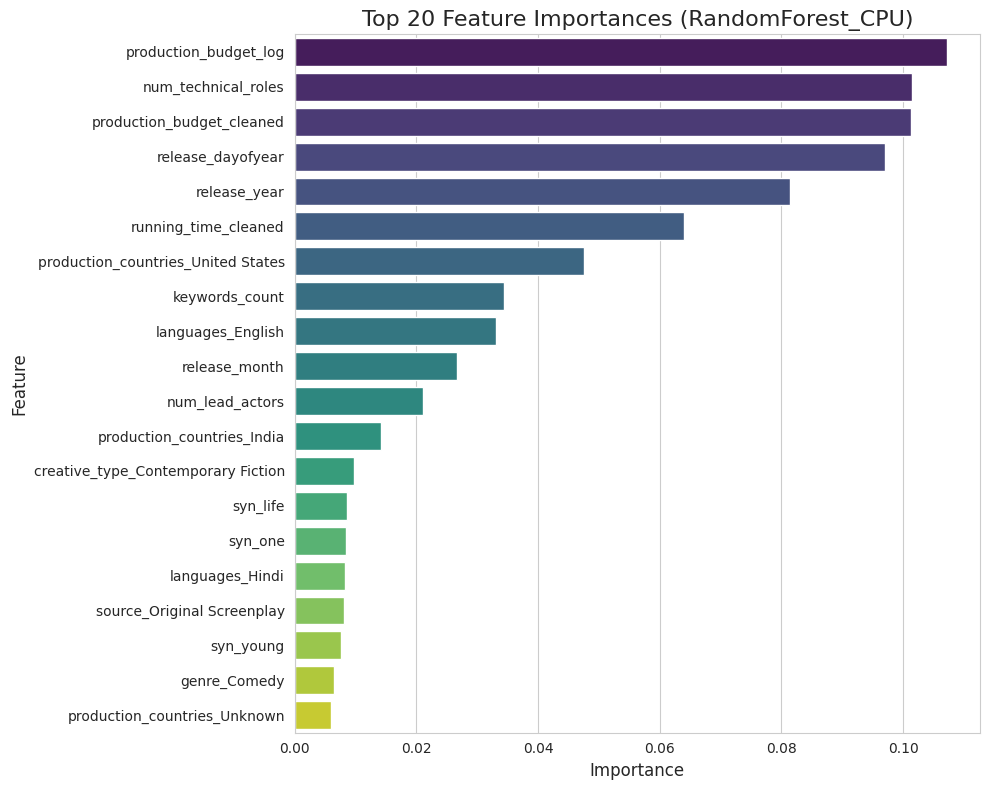

In [238]:
# Compare model results
print("\nComparison of model results:")

results_df = pd.DataFrame(results).T
results_df = results_df.sort_values(by="MdAPE (Original)", ascending=True)

# Format currency and percentage columns
currency_cols = ["RMSE (Original)", "MAE (Original)"]
for col in currency_cols:
    if col in results_df.columns:
        results_df[col] = results_df[col].apply(
            lambda x: f"${x:,.0f}"
            if pd.notnull(x) and isinstance(x, (int, float))
            else "N/A"
        )

percentage_cols = ["MAPE (Original)", "MdAPE (Original)"]
for col in percentage_cols:
    if col in results_df.columns:
        results_df[col] = results_df[col].apply(
            lambda x: f"{x:.2f}%"
            if pd.notnull(x) and isinstance(x, (int, float))
            else "N/A"
        )

# Display relevant columns
cols_to_display = [
    "MdAPE (Original)",
    "MAPE (Original)",
    "RMSE (Original)",
    "MAE (Original)",
    "R2 (Log)",
    "RMSE (Log)",
    "Time (s)",
    "Best Params",
]
if "Error" in results_df.columns:
    cols_to_display.append("Error")
    results_df_display = results_df[cols_to_display].copy()
    results_df_display["Error"] = results_df_display["Error"].fillna("")
else:
    results_df_display = results_df[cols_to_display].copy()

print(results_df_display.to_markdown())

# Feature importance for the best model by MdAPE
print("\nAnalyzing feature importance for best model...")

valid_results_df = results_df.dropna(subset=["Best Estimator"])
if not valid_results_df.empty:
    best_model_name = valid_results_df.index[0]
    best_model_info = valid_results_df.loc[best_model_name]
    best_model_obj = best_model_info["Best Estimator"]
    print(f"Best model: {best_model_name}")

    try:
        # Extract the actual model from pipeline if needed
        model_step = (
            best_model_obj.named_steps["model"]
            if hasattr(best_model_obj, "steps")
            else best_model_obj
        )

        if hasattr(model_step, "feature_importances_"):
            importances = model_step.feature_importances_
            feature_names = X.columns

            if len(importances) == len(feature_names):
                feature_importance_df = pd.DataFrame(
                    {"Feature": feature_names, "Importance": importances}
                ).sort_values(by="Importance", ascending=False)

                print(f"\nTop 20 Features by Importance for {best_model_name}:")
                print(feature_importance_df.head(20).to_markdown(index=False))

                plt.figure(figsize=(10, 8))
                sns.barplot(
                    x="Importance",
                    y="Feature",
                    data=feature_importance_df.head(20),
                    palette="viridis",
                    hue="Feature",
                    legend=False,
                )
                plt.title(f"Top 20 Feature Importances ({best_model_name})")
                plt.xlabel("Importance")
                plt.ylabel("Feature")
                plt.tight_layout()
                plt.show()
            else:
                print("Mismatch between number of importances and features.")

        elif hasattr(model_step, "coef_"):
            coefficients = model_step.coef_
            feature_names = X.columns

            if len(coefficients) == len(feature_names):
                coef_df = pd.DataFrame(
                    {
                        "Feature": feature_names,
                        "Coefficient": coefficients,
                        "Abs_Coefficient": np.abs(coefficients),
                    }
                ).sort_values(by="Abs_Coefficient", ascending=False)

                print("\nTop 20 Features by Absolute Coefficient:")
                print(
                    coef_df[["Feature", "Coefficient"]]
                    .head(20)
                    .to_markdown(index=False)
                )
            else:
                print("Mismatch between number of coefficients and features.")
        else:
            print("Model does not expose feature importances or coefficients.")

    except Exception as e:
        print(f"Could not retrieve feature importances. Error: {e}")
else:
    print("No valid models trained successfully. Skipping feature importance.")


# Conclusion

In this notebook, we explored a comprehensive pipeline for predicting the opening weekend gross of movies. The process involved several key steps:

1. **Data Preprocessing**: We cleaned and transformed the dataset by handling missing values, cleaning numerical and categorical columns, and extracting meaningful features from complex data structures.
2. **Feature Engineering**: We applied advanced techniques such as one-hot encoding, top-N encoding for actors and roles, and TF-IDF vectorization for textual data like movie synopses.
3. **Exploratory Data Analysis (EDA)**: Through visualizations, we analyzed the distribution of the target variable, relationships between features, and temporal patterns in the data.
4. **Outlier Detection and Removal**: Using the IQR method, we identified and removed outliers to ensure the dataset was representative of the majority distribution.
5. **Clustering**: We grouped movies into clusters based on their features and trained separate models for each cluster to capture unique patterns.
6. **Model Training and Evaluation**: Multiple machine learning models, including Ridge, Lasso, Random Forest, XGBoost, and LightGBM, were trained and evaluated using metrics such as R-squared, RMSE, MAE, MAPE, and MdAPE. Hyperparameter tuning was performed using GridSearchCV to optimize model performance.
7. **Feature Importance Analysis**: We identified the most influential features for the best-performing model, providing insights into the factors driving opening weekend gross.

### Key Takeaways:
- **Feature Engineering**: Incorporating domain-specific features, such as top actors and production companies, significantly improved model performance.
- **Clustering**: Tailoring models to specific clusters allowed us to better capture the heterogeneity in the dataset.
- **Model Performance**: XGBoost and LightGBM demonstrated strong predictive capabilities, particularly on the log-transformed target variable.
